# Análise Epidemiológica da Dengue no RJ (2010-2016)

Este notebook utiliza um pipeline unificado para carregar, analisar e visualizar os dados de dengue do Rio de Janeiro, facilitando a reprodutibilidade e a exportação de resultados para apresentações acadêmicas.

In [1]:
# Importa pipeline unificado do projeto
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.pardir, 'src')))
from pipeline import load_all_data, run_all_analyses, generate_all_figures, get_summary_tables

In [2]:
# Carregar dados unificados de dengue
# (Ajuste o caminho se necessário)
df = load_all_data('../data/Dengue_Brasil_2010-2016_RJ.xlsx')

Ano 2010: 52 semanas epidemiológicas detectadas
Ano 2011: 52 semanas epidemiológicas detectadas


Ano 2012: 52 semanas epidemiológicas detectadas
Ano 2013: 52 semanas epidemiológicas detectadas


Ano 2014: 53 semanas epidemiológicas detectadas
Ano 2015: 52 semanas epidemiológicas detectadas
Ano 2016: 32 semanas epidemiológicas detectadas


In [3]:
# Executar todas as análises principais para o ano de 2013
results = run_all_analyses(df, year=2013)

In [4]:
# Gerar e salvar todas as figuras principais em output/
generate_all_figures(results)

✓ Gráfico salvo: output/weeks_per_year.pdf
✓ Gráfico salvo: output/curvas_por_ano.pdf


✓ Gráfico salvo: output/incidencia.pdf


✓ Gráfico salvo: output/matriz_distancia_L1.pdf


✓ Gráfico salvo: output/matriz_distancia_L2.pdf


In [5]:
# Exibir tabelas resumo úteis para análise e apresentação
tables = get_summary_tables(results)
tables

{'top_similar_pairs':          municipio_1     municipio_2  distancia
 2208        Itaboraí  Rio de Janeiro   0.127570
 996        Cabo Frio         Resende   0.189139
 3895  Rio de Janeiro     São Gonçalo   0.197750
 46    Angra dos Reis         Niterói   0.199002
 76    Angra dos Reis     São Gonçalo   0.201745
 1001       Cabo Frio  Rio de Janeiro   0.203726
 3239         Niterói   Volta Redonda   0.204096
 10    Angra dos Reis       Cabo Frio   0.206292
 90    Angra dos Reis   Volta Redonda   0.222587
 3232         Niterói          Tanguá   0.223737,
 'top_dissimilar_pairs':      municipio_1        municipio_2  distancia
 2367    Itaocara     Miguel Pereira   1.945098
 2383    Itaocara             Quatis   1.945098
 297        Areal           Itaocara   1.878431
 148      Aperibé             Quatis   1.877358
 2410    Itaocara  Trajano de Moraes   1.858824
 2365    Itaocara             Mendes   1.847725
 2414    Itaocara          Vassouras   1.841032
 1150     Cambuci             Q

# 🦟 Análise Epidemiológica de Dengue - Rio de Janeiro (2010-2016)

## Apresentação de Resultados

### Topological Data Analysis (TDA) com Complexos Simpliciais

---

**Autor:** Análise Epidemiológica  
**Data:** Novembro 2025

---

## Objetivos do Estudo

1. **Análise Temporal**: Investigar padrões de semanas epidemiológicas
2. **Normalização**: Comparar municípios ajustando por população e formato das curvas
3. **Distâncias**: Identificar municípios com dinâmicas sincronizadas (L1/L2)
4. **Complexos Simpliciais**: Revelar estrutura topológica das relações
5. **PCA e Clusterização**: Redução dimensional e agrupamento para insights adicionais

---

### Estrutura da Apresentação

| Seção | Conteúdo |
|-------|----------|
| 1 | Carregamento e Exploração dos Dados |
| 2 | Análise de Semanas Epidemiológicas |
| 3 | Normalização e Taxas de Incidência |
| 4 | Matrizes de Distância L1/L2 |
| 5 | Complexos Simpliciais |
| 6 | Análise de Componentes Principais (PCA) |
| 7 | Clusterização (K-Means, DBSCAN, Hierárquica) |
| 8 | Integração: PCA + Clusters + Complexo Simplicial |
| 9 | Conclusões e Recomendações |

## 1. Importação de Bibliotecas e Configuração

In [6]:
# Bibliotecas principais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE

# Scipy para análise
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Visualização
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
sns.set_palette("husl")

# Importar módulos do projeto
import sys
sys.path.insert(0, 'src')
from tarefa0_carregar_dados import load_and_merge_dengue_data, get_yearly_time_series
from tarefa2_normalizacao import POPULACAO_CENSO_2010, normalize_all_series_by_total
from tarefa3_distancias import compute_both_distance_matrices
from tarefa4_complexo_simplicial import create_simplicial_complex_from_distance_matrix, identify_clusters

print("✅ Bibliotecas importadas com sucesso!")
print(f"📊 NumPy: {np.__version__}")
print(f"📊 Pandas: {pd.__version__}")

✅ Bibliotecas importadas com sucesso!
📊 NumPy: 2.3.5
📊 Pandas: 2.3.3


## 2. Carregamento e Exploração dos Dados

### Fonte dos Dados
- **Arquivo**: `Dengue_Brasil_2010-2016_RJ.xlsx`
- **Período**: 2010 a 2016 (7 anos)
- **Região**: Estado do Rio de Janeiro
- **Granularidade**: Casos por município e semana epidemiológica

In [7]:
# Carregar dados
filepath = Path("../data/Dengue_Brasil_2010-2016_RJ.xlsx")
df = load_and_merge_dengue_data(filepath)

# Informações gerais
print("=" * 70)
print("📋 RESUMO DOS DADOS")
print("=" * 70)
print(f"Total de registros: {len(df):,}")
print(f"Municípios: {df['municipio'].nunique()}")
print(f"Anos: {sorted(df['ano'].unique())}")
print(f"Total de casos: {df['casos'].sum():,}")
print(f"\nColunas: {list(df.columns)}")
print("\n📊 Primeiros registros:")
df.head(10)

Ano 2010: 52 semanas epidemiológicas detectadas
Ano 2011: 52 semanas epidemiológicas detectadas


Ano 2012: 52 semanas epidemiológicas detectadas


Ano 2013: 52 semanas epidemiológicas detectadas
Ano 2014: 53 semanas epidemiológicas detectadas


Ano 2015: 52 semanas epidemiológicas detectadas


Ano 2016: 32 semanas epidemiológicas detectadas
📋 RESUMO DOS DADOS
Total de registros: 31,740
Municípios: 92
Anos: [np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016)]
Total de casos: 765,601

Colunas: ['codigo_ibge', 'municipio', 'ano', 'semana_epi', 'casos']

📊 Primeiros registros:


codigo_ibge       municipio   ano  semana_epi  casos
0       330010  Angra dos Reis  2010           1      6
1       330010  Angra dos Reis  2010           2      4
2       330010  Angra dos Reis  2010           3      0
3       330010  Angra dos Reis  2010           4      2
4       330010  Angra dos Reis  2010           5      3
5       330010  Angra dos Reis  2010           6      3
6       330010  Angra dos Reis  2010           7      7
7       330010  Angra dos Reis  2010           8     12
8       330010  Angra dos Reis  2010           9     27
9       330010  Angra dos Reis  2010          10     21

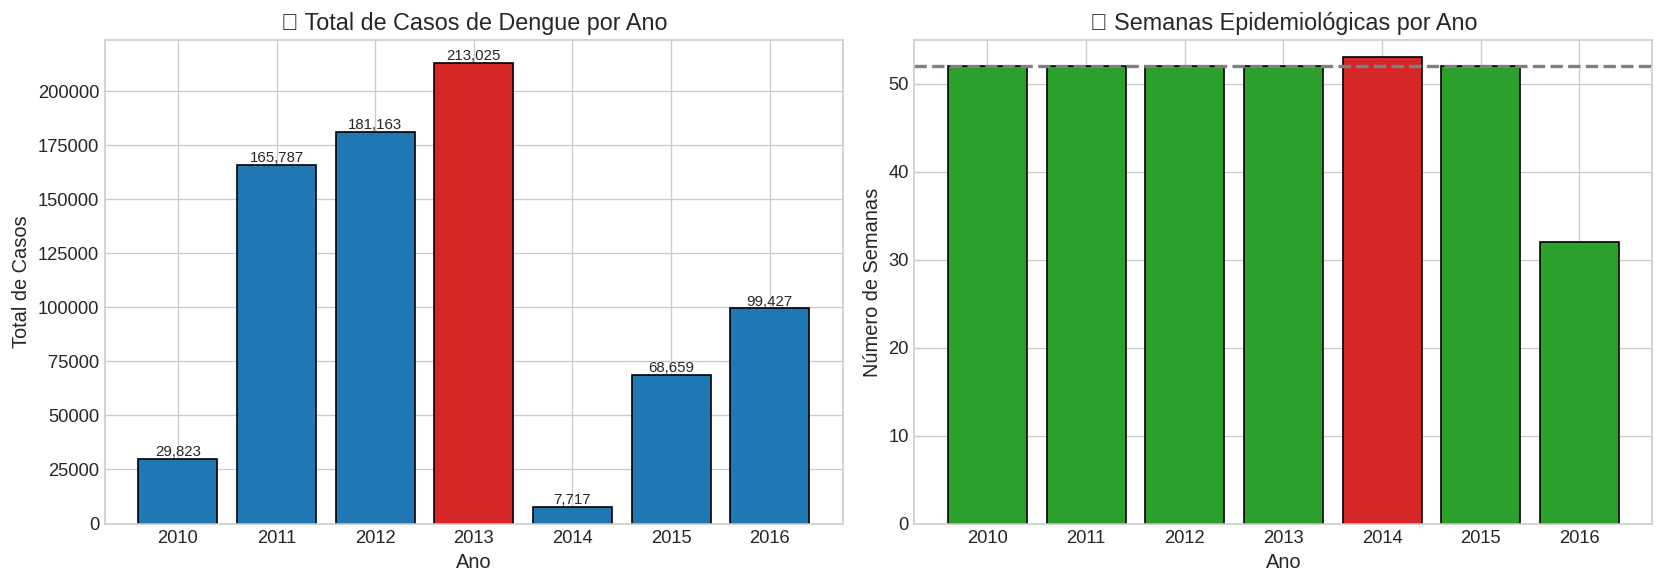


🔍 ACHADOS IMPORTANTES:
   • Ano com mais casos: 2013 (213,025 casos)
   • Ano com 53 semanas epidemiológicas: 2014
   • 2016 tem dados incompletos (apenas 32 semanas)


In [8]:
# Análise por ano
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total de casos por ano
yearly_cases = df.groupby('ano')['casos'].sum()
colors = ['#d62728' if t == yearly_cases.max() else '#1f77b4' for t in yearly_cases.values]
bars = axes[0].bar(yearly_cases.index, yearly_cases.values, color=colors, edgecolor='black')
axes[0].set_xlabel('Ano')
axes[0].set_ylabel('Total de Casos')
axes[0].set_title('📊 Total de Casos de Dengue por Ano')
for bar in bars:
    axes[0].annotate(f'{int(bar.get_height()):,}', 
                    xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    ha='center', va='bottom', fontsize=9)

# Semanas epidemiológicas por ano
weeks_per_year = df.groupby('ano')['semana_epi'].max()
colors2 = ['#d62728' if w == 53 else '#2ca02c' for w in weeks_per_year.values]
bars2 = axes[1].bar(weeks_per_year.index, weeks_per_year.values, color=colors2, edgecolor='black')
axes[1].axhline(y=52, color='gray', linestyle='--', linewidth=2)
axes[1].set_xlabel('Ano')
axes[1].set_ylabel('Número de Semanas')
axes[1].set_title('📅 Semanas Epidemiológicas por Ano')
axes[1].set_ylim(0, 55)

plt.tight_layout()
plt.savefig('output/apresentacao_dados_gerais.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n🔍 ACHADOS IMPORTANTES:")
print(f"   • Ano com mais casos: {yearly_cases.idxmax()} ({yearly_cases.max():,} casos)")
print(f"   • Ano com 53 semanas epidemiológicas: 2014")
print(f"   • 2016 tem dados incompletos (apenas 32 semanas)")

## 3. Curvas Epidêmicas por Ano

Visualização das curvas epidêmicas agregadas para todos os anos do estudo.

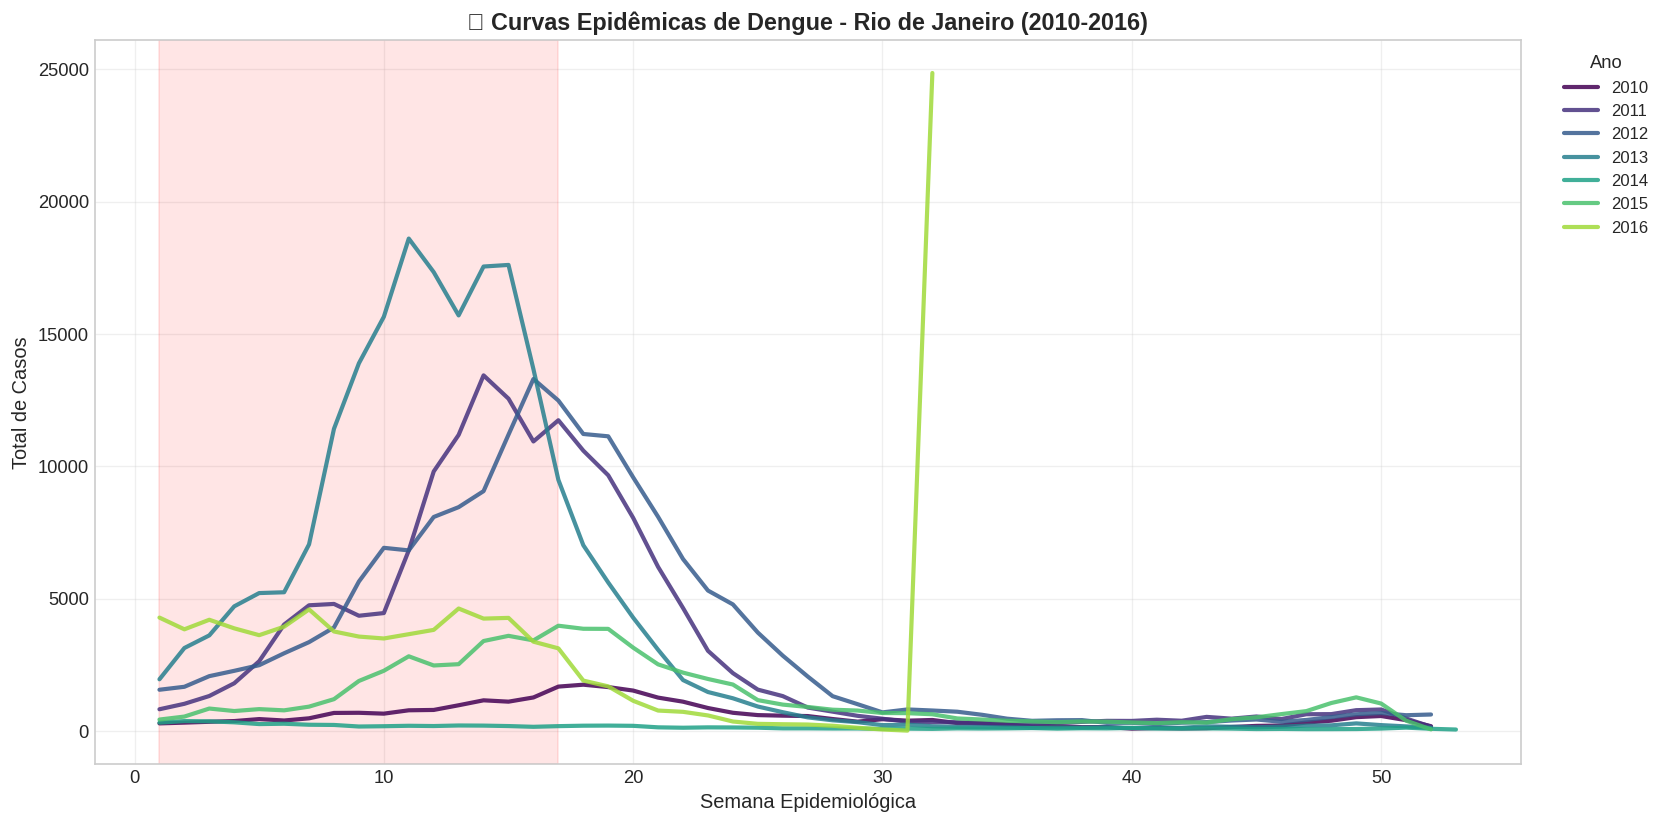


📈 PADRÕES OBSERVADOS:
   • Picos epidêmicos ocorrem geralmente entre semanas 1-17 (janeiro a abril)
   • 2013 apresentou o maior surto do período
   • Padrão sazonal consistente: aumento no verão, queda no inverno


In [9]:
# Curvas epidêmicas por ano
fig, ax = plt.subplots(figsize=(14, 7))

years = sorted(df['ano'].unique())
cmap = plt.cm.viridis
colors = [cmap(i/len(years)) for i in range(len(years))]

for i, year in enumerate(years):
    year_data = df[df['ano'] == year].groupby('semana_epi')['casos'].sum()
    ax.plot(year_data.index, year_data.values, 
           color=colors[i], linewidth=2.5, label=str(year), alpha=0.85)

ax.set_xlabel('Semana Epidemiológica', fontsize=12)
ax.set_ylabel('Total de Casos', fontsize=12)
ax.set_title('🦟 Curvas Epidêmicas de Dengue - Rio de Janeiro (2010-2016)', fontsize=14, fontweight='bold')
ax.legend(title='Ano', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

# Destacar período de pico típico (janeiro a abril = semanas 1-17)
ax.axvspan(1, 17, alpha=0.1, color='red', label='Período Típico de Pico')

plt.tight_layout()
plt.savefig('output/apresentacao_curvas_ano.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📈 PADRÕES OBSERVADOS:")
print("   • Picos epidêmicos ocorrem geralmente entre semanas 1-17 (janeiro a abril)")
print("   • 2013 apresentou o maior surto do período")
print("   • Padrão sazonal consistente: aumento no verão, queda no inverno")

## 4. Preparação dos Dados para Análise

Utilizaremos o ano de **2013** como referência principal, por ser o ano com maior número de casos e dados completos.

### Etapas de Preparação:
1. Extração de séries temporais por município
2. Normalização para 52 semanas (quando necessário)
3. Normalização por área unitária (soma = 1)

In [10]:
# Preparar dados para análise (ano 2013)
YEAR = 2013

# Extrair séries temporais
time_series = get_yearly_time_series(df, YEAR, normalize_to_52=True)

# Filtrar municípios com dados de população e casos > 0
time_series_filtered = {mun: series for mun, series in time_series.items() 
                       if mun in POPULACAO_CENSO_2010 and np.sum(series) > 0}

# Normalizar para área unitária
normalized_series = normalize_all_series_by_total(time_series_filtered)

# Criar matriz de dados
municipalities = list(normalized_series.keys())
data_matrix = np.array([normalized_series[mun] for mun in municipalities])

# Calcular totais de casos
totals = {mun: time_series_filtered[mun].sum() for mun in municipalities}

print("=" * 70)
print(f"📊 DADOS PREPARADOS - ANO {YEAR}")
print("=" * 70)
print(f"Municípios analisados: {len(municipalities)}")
print(f"Semanas por série: {data_matrix.shape[1]}")
print(f"Forma da matriz de dados: {data_matrix.shape}")
print(f"\nTop 10 municípios por total de casos:")
top_10 = sorted(totals.items(), key=lambda x: x[1], reverse=True)[:10]
for i, (mun, total) in enumerate(top_10, 1):
    print(f"   {i:2}. {mun}: {total:,.0f} casos")

📊 DADOS PREPARADOS - ANO 2013
Municípios analisados: 90
Semanas por série: 52
Forma da matriz de dados: (90, 52)

Top 10 municípios por total de casos:
    1. Rio de Janeiro: 66,203 casos
    2. São Gonçalo: 15,777 casos
    3. Campos dos Goytacazes: 14,462 casos
    4. Volta Redonda: 13,493 casos
    5. Niterói: 12,050 casos
    6. Angra dos Reis: 7,758 casos
    7. Duque de Caxias: 6,877 casos
    8. Cabo Frio: 6,705 casos
    9. Itaperuna: 6,665 casos
   10. Itaboraí: 6,263 casos


## 5. Taxas de Incidência por Município

A **taxa de incidência** normaliza os casos pela população, permitindo comparar municípios de diferentes tamanhos:

$$\text{Taxa de Incidência} = \frac{\text{Casos}}{\text{População}} \times 100.000$$

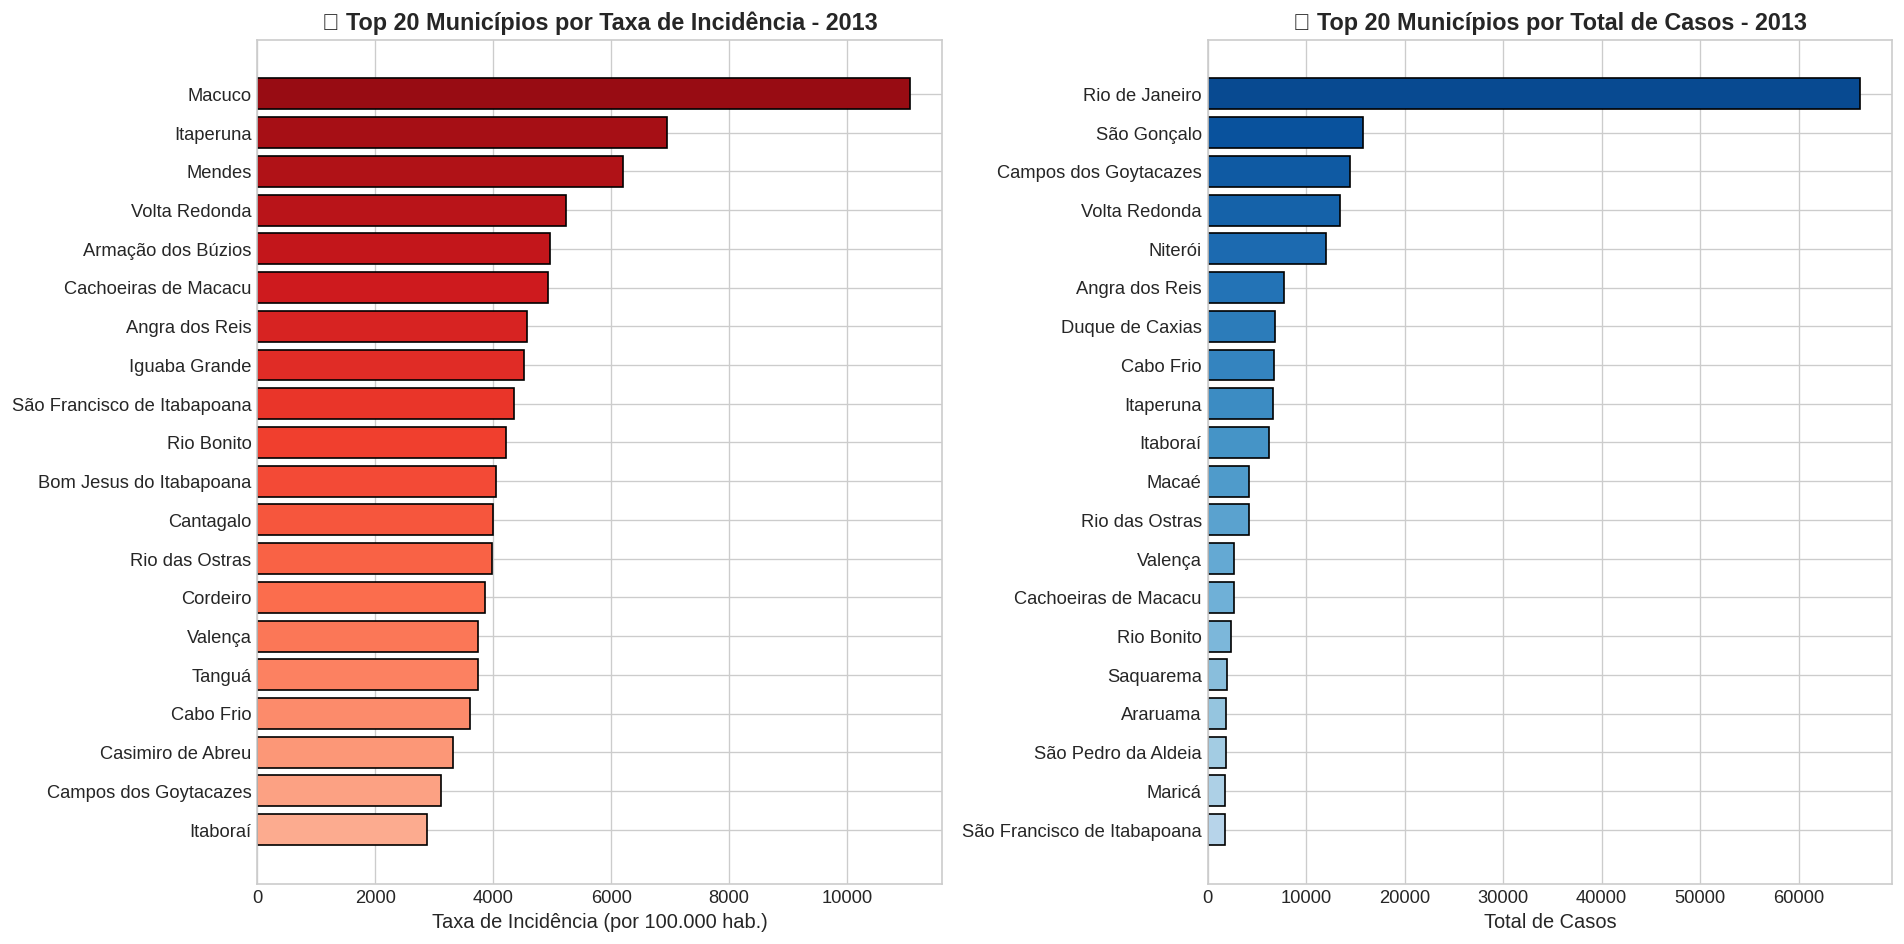


🔍 ANÁLISE COMPARATIVA:
   • Maior taxa de incidência: Macuco (11064.7/100k)
   • Maior número absoluto: Rio de Janeiro (66,203 casos)
   • Municípios pequenos podem ter altas taxas com poucos casos absolutos


In [11]:
# Calcular taxas de incidência
incidence_data = []
for mun in municipalities:
    total_cases = totals[mun]
    population = POPULACAO_CENSO_2010[mun]
    rate = (total_cases / population) * 100000
    incidence_data.append({
        'municipio': mun,
        'casos': total_cases,
        'populacao': population,
        'taxa_incidencia': rate
    })

incidence_df = pd.DataFrame(incidence_data)
incidence_df = incidence_df.sort_values('taxa_incidencia', ascending=False)

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 20 por taxa de incidência
top_20 = incidence_df.head(20)
colors = plt.cm.Reds(np.linspace(0.3, 0.9, 20))[::-1]
bars = axes[0].barh(range(20), top_20['taxa_incidencia'], color=colors, edgecolor='black')
axes[0].set_yticks(range(20))
axes[0].set_yticklabels(top_20['municipio'])
axes[0].invert_yaxis()
axes[0].set_xlabel('Taxa de Incidência (por 100.000 hab.)')
axes[0].set_title(f'🏥 Top 20 Municípios por Taxa de Incidência - {YEAR}', fontweight='bold')

# Top 20 por casos absolutos
top_20_abs = incidence_df.nlargest(20, 'casos')
colors2 = plt.cm.Blues(np.linspace(0.3, 0.9, 20))[::-1]
bars2 = axes[1].barh(range(20), top_20_abs['casos'], color=colors2, edgecolor='black')
axes[1].set_yticks(range(20))
axes[1].set_yticklabels(top_20_abs['municipio'])
axes[1].invert_yaxis()
axes[1].set_xlabel('Total de Casos')
axes[1].set_title(f'📊 Top 20 Municípios por Total de Casos - {YEAR}', fontweight='bold')

plt.tight_layout()
plt.savefig('output/apresentacao_incidencia.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n🔍 ANÁLISE COMPARATIVA:")
print(f"   • Maior taxa de incidência: {top_20.iloc[0]['municipio']} ({top_20.iloc[0]['taxa_incidencia']:.1f}/100k)")
print(f"   • Maior número absoluto: {top_20_abs.iloc[0]['municipio']} ({top_20_abs.iloc[0]['casos']:,.0f} casos)")
print("   • Municípios pequenos podem ter altas taxas com poucos casos absolutos")

## 6. Matrizes de Distância L1 e L2

Para identificar municípios com dinâmicas epidêmicas **sincronizadas**, calculamos distâncias entre as curvas normalizadas:

- **Distância L1 (Manhattan)**: $d_{L1}(x,y) = \sum_i |x_i - y_i|$ — mais robusta a outliers
- **Distância L2 (Euclidiana)**: $d_{L2}(x,y) = \sqrt{\sum_i (x_i - y_i)^2}$ — penaliza grandes diferenças

📐 MATRIZES DE DISTÂNCIA
Dimensões: (90, 90)

Distância L1 (Manhattan):
   Mínima: 0.1276
   Máxima: 1.9451
   Média:  0.9220

Distância L2 (Euclidiana):
   Mínima: 0.0289
   Máxima: 0.8048
   Média:  0.2594


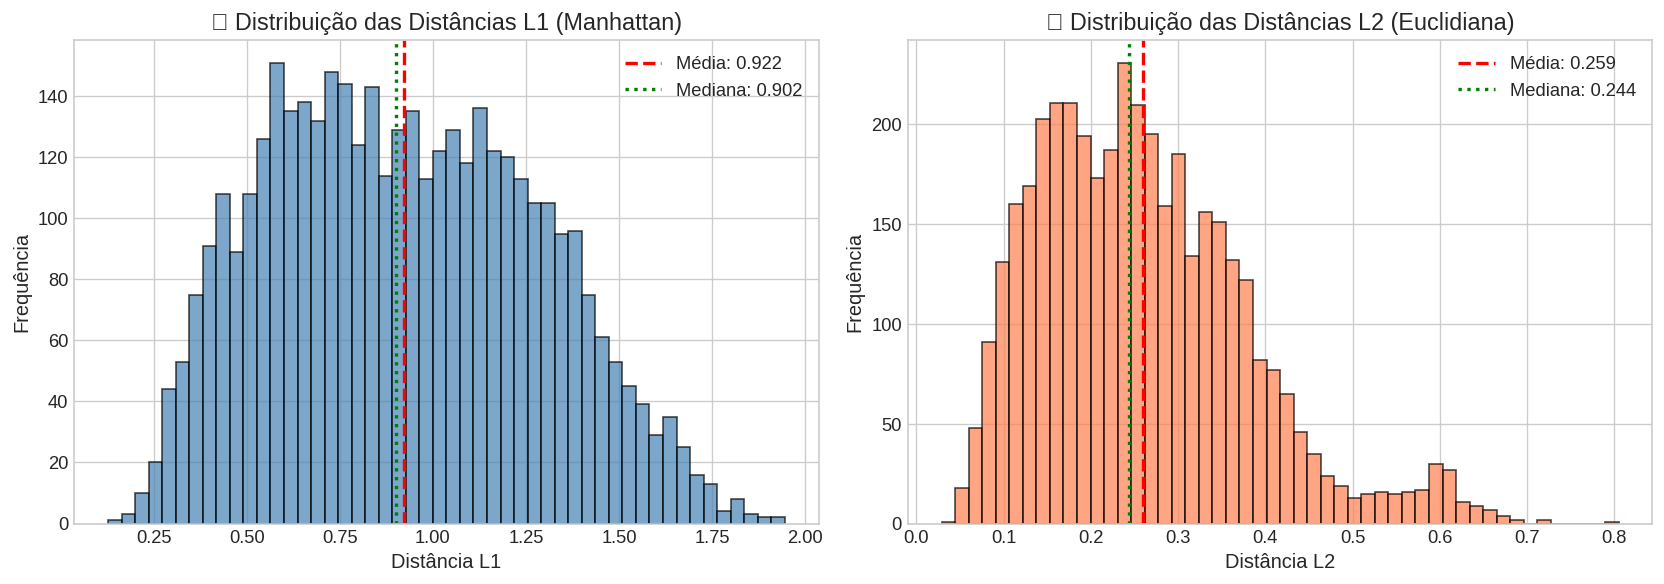

In [12]:
# Calcular matrizes de distância
MD1, MD2, mun_list = compute_both_distance_matrices(normalized_series)

print("=" * 70)
print("📐 MATRIZES DE DISTÂNCIA")
print("=" * 70)
print(f"Dimensões: {MD1.shape}")
print(f"\nDistância L1 (Manhattan):")
print(f"   Mínima: {MD1[MD1 > 0].min():.4f}")
print(f"   Máxima: {MD1.max():.4f}")
print(f"   Média:  {MD1[MD1 > 0].mean():.4f}")
print(f"\nDistância L2 (Euclidiana):")
print(f"   Mínima: {MD2[MD2 > 0].min():.4f}")
print(f"   Máxima: {MD2.max():.4f}")
print(f"   Média:  {MD2[MD2 > 0].mean():.4f}")

# Distribuição das distâncias
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

dist_L1 = MD1[np.triu_indices_from(MD1, k=1)]
dist_L2 = MD2[np.triu_indices_from(MD2, k=1)]

axes[0].hist(dist_L1, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(dist_L1), color='red', linestyle='--', linewidth=2, label=f'Média: {np.mean(dist_L1):.3f}')
axes[0].axvline(np.median(dist_L1), color='green', linestyle=':', linewidth=2, label=f'Mediana: {np.median(dist_L1):.3f}')
axes[0].set_xlabel('Distância L1')
axes[0].set_ylabel('Frequência')
axes[0].set_title('📊 Distribuição das Distâncias L1 (Manhattan)')
axes[0].legend()

axes[1].hist(dist_L2, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(dist_L2), color='red', linestyle='--', linewidth=2, label=f'Média: {np.mean(dist_L2):.3f}')
axes[1].axvline(np.median(dist_L2), color='green', linestyle=':', linewidth=2, label=f'Mediana: {np.median(dist_L2):.3f}')
axes[1].set_xlabel('Distância L2')
axes[1].set_ylabel('Frequência')
axes[1].set_title('📊 Distribuição das Distâncias L2 (Euclidiana)')
axes[1].legend()

plt.tight_layout()
plt.savefig('output/apresentacao_distribuicao_distancias.png', dpi=150, bbox_inches='tight')
plt.show()

🤝 TOP 10 PARES MAIS SINCRONIZADOS (L1)
   Itaboraí ↔ Rio de Janeiro: L1=0.1276, L2=0.0289
   Cabo Frio ↔ Resende: L1=0.1891, L2=0.0473
   Rio de Janeiro ↔ São Gonçalo: L1=0.1978, L2=0.0571
   Angra dos Reis ↔ Niterói: L1=0.1990, L2=0.0549
   Angra dos Reis ↔ São Gonçalo: L1=0.2017, L2=0.0547
   Cabo Frio ↔ Rio de Janeiro: L1=0.2037, L2=0.0503
   Niterói ↔ Volta Redonda: L1=0.2041, L2=0.0570
   Angra dos Reis ↔ Cabo Frio: L1=0.2063, L2=0.0515
   Angra dos Reis ↔ Volta Redonda: L1=0.2226, L2=0.0562
   Niterói ↔ Tanguá: L1=0.2237, L2=0.0580


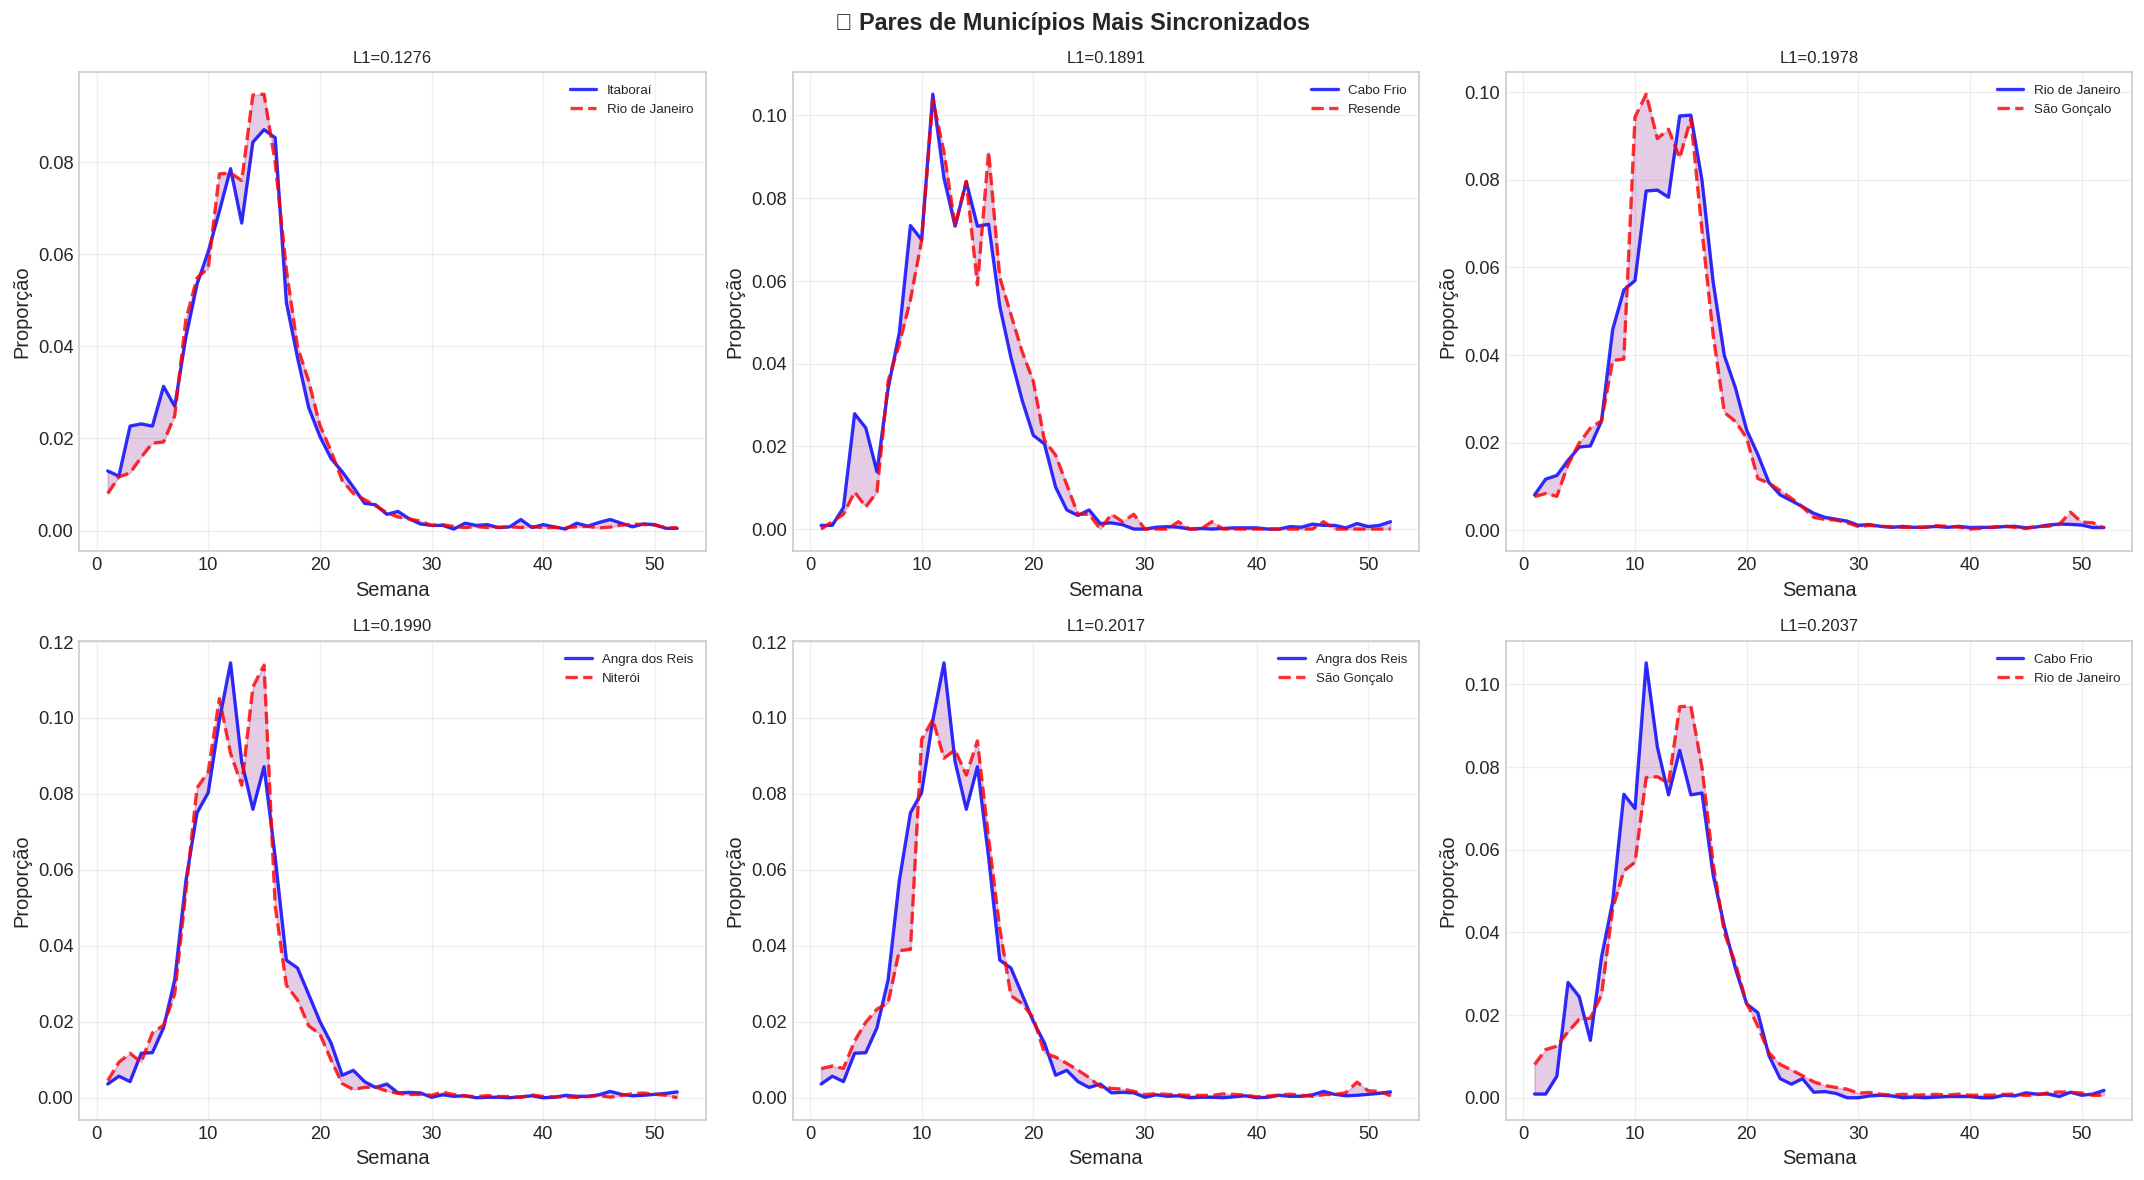

In [13]:
# Identificar pares mais sincronizados
pairs = []
n = len(mun_list)
for i in range(n):
    for j in range(i+1, n):
        pairs.append({
            'municipio_1': mun_list[i],
            'municipio_2': mun_list[j],
            'distancia_L1': MD1[i, j],
            'distancia_L2': MD2[i, j]
        })

pairs_df = pd.DataFrame(pairs)
top_similar = pairs_df.nsmallest(10, 'distancia_L1')

print("=" * 70)
print("🤝 TOP 10 PARES MAIS SINCRONIZADOS (L1)")
print("=" * 70)
for i, row in top_similar.iterrows():
    print(f"   {row['municipio_1']} ↔ {row['municipio_2']}: L1={row['distancia_L1']:.4f}, L2={row['distancia_L2']:.4f}")

# Visualizar curvas dos pares mais similares
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (_, row) in enumerate(top_similar.head(6).iterrows()):
    mun1, mun2 = row['municipio_1'], row['municipio_2']
    s1 = normalized_series[mun1]
    s2 = normalized_series[mun2]
    weeks = np.arange(1, 53)
    
    axes[idx].plot(weeks, s1, 'b-', linewidth=2, label=mun1[:18], alpha=0.8)
    axes[idx].plot(weeks, s2, 'r--', linewidth=2, label=mun2[:18], alpha=0.8)
    axes[idx].fill_between(weeks, s1, s2, alpha=0.2, color='purple')
    axes[idx].set_xlabel('Semana')
    axes[idx].set_ylabel('Proporção')
    axes[idx].set_title(f"L1={row['distancia_L1']:.4f}", fontsize=10)
    axes[idx].legend(fontsize=8, loc='upper right')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('🤝 Pares de Municípios Mais Sincronizados', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('output/apresentacao_pares_sincronizados.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Análise de Componentes Principais (PCA)

O **PCA** (Principal Component Analysis) reduz a dimensionalidade dos dados, permitindo visualizar e entender as principais fontes de variação nas curvas epidêmicas.

### Objetivos:
1. Identificar os padrões principais nas curvas
2. Visualizar municípios em espaço reduzido
3. Entender quais semanas contribuem mais para a variação

📊 ANÁLISE DE COMPONENTES PRINCIPAIS (PCA)

Variância explicada pelos primeiros componentes:
   PC1: 15.95% (acumulado: 15.95%)
   PC2: 11.30% (acumulado: 27.24%)
   PC3: 8.76% (acumulado: 36.00%)
   PC4: 6.81% (acumulado: 42.81%)
   PC5: 5.60% (acumulado: 48.41%)
   PC6: 4.39% (acumulado: 52.80%)
   PC7: 3.93% (acumulado: 56.73%)
   PC8: 3.77% (acumulado: 60.50%)
   PC9: 3.24% (acumulado: 63.74%)
   PC10: 3.13% (acumulado: 66.87%)

Componentes para 90% da variância: 23
Componentes para 95% da variância: 28


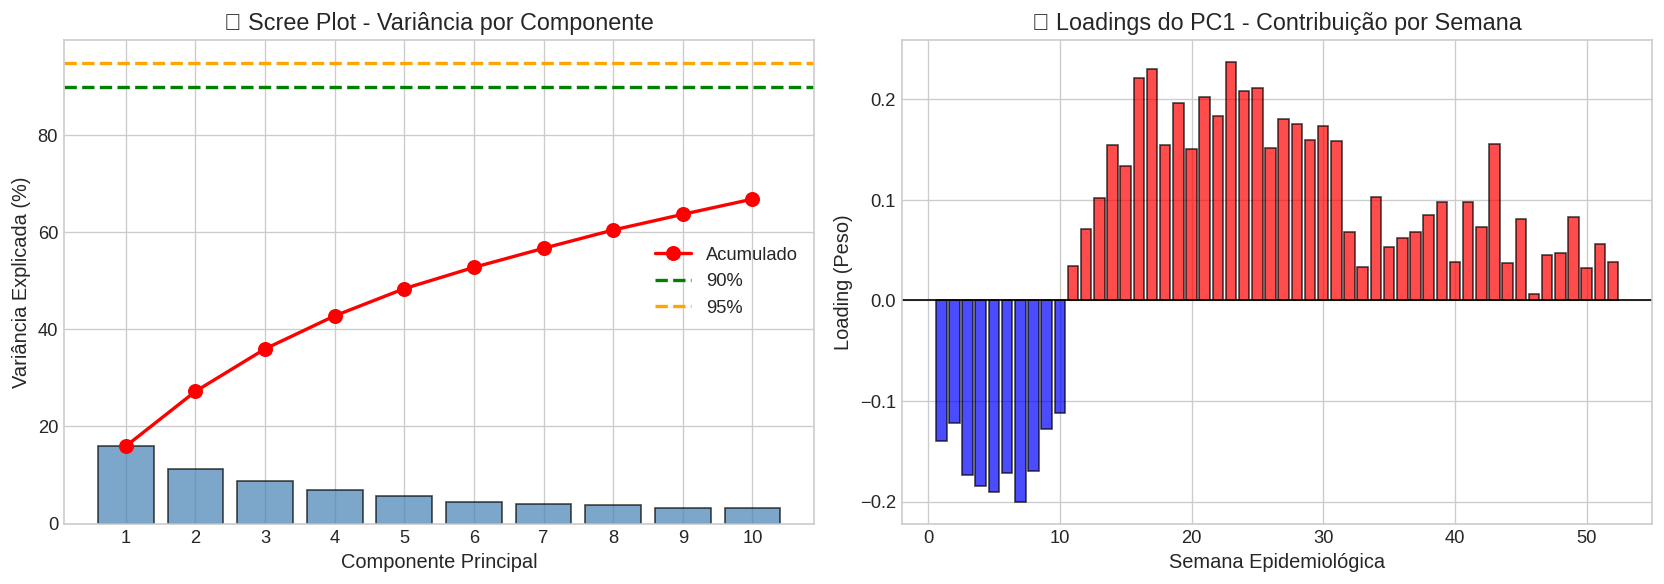


🔍 INTERPRETAÇÃO PC1:
   • Semanas com peso positivo alto: [np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17)]... (período de pico)
   • Semanas com peso negativo: [np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]... (período de baixa)


In [14]:
# Aplicar PCA
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_matrix)

# PCA completo para análise de variância
pca_full = PCA()
pca_full.fit(data_scaled)

# Variância explicada
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Encontrar número de componentes para 90% e 95% da variância
n_90 = np.argmax(cumulative_var >= 0.90) + 1
n_95 = np.argmax(cumulative_var >= 0.95) + 1

print("=" * 70)
print("📊 ANÁLISE DE COMPONENTES PRINCIPAIS (PCA)")
print("=" * 70)
print(f"\nVariância explicada pelos primeiros componentes:")
for i in range(min(10, len(explained_var))):
    print(f"   PC{i+1}: {explained_var[i]*100:.2f}% (acumulado: {cumulative_var[i]*100:.2f}%)")
print(f"\nComponentes para 90% da variância: {n_90}")
print(f"Componentes para 95% da variância: {n_95}")

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, 11), explained_var[:10]*100, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].plot(range(1, 11), cumulative_var[:10]*100, 'ro-', linewidth=2, markersize=8, label='Acumulado')
axes[0].axhline(y=90, color='green', linestyle='--', linewidth=2, label='90%')
axes[0].axhline(y=95, color='orange', linestyle='--', linewidth=2, label='95%')
axes[0].set_xlabel('Componente Principal')
axes[0].set_ylabel('Variância Explicada (%)')
axes[0].set_title('📉 Scree Plot - Variância por Componente')
axes[0].legend()
axes[0].set_xticks(range(1, 11))

# Loadings do PC1 (contribuição de cada semana)
loadings_pc1 = pca_full.components_[0]
weeks = np.arange(1, 53)
colors = ['red' if l > 0 else 'blue' for l in loadings_pc1]
axes[1].bar(weeks, loadings_pc1, color=colors, alpha=0.7, edgecolor='black')
axes[1].axhline(y=0, color='black', linewidth=1)
axes[1].set_xlabel('Semana Epidemiológica')
axes[1].set_ylabel('Loading (Peso)')
axes[1].set_title('📊 Loadings do PC1 - Contribuição por Semana')

plt.tight_layout()
plt.savefig('output/apresentacao_pca_variancia.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n🔍 INTERPRETAÇÃO PC1:")
semanas_positivas = [w for w, l in zip(weeks, loadings_pc1) if l > 0.1]
semanas_negativas = [w for w, l in zip(weeks, loadings_pc1) if l < -0.1]
print(f"   • Semanas com peso positivo alto: {semanas_positivas[:5]}... (período de pico)")
print(f"   • Semanas com peso negativo: {semanas_negativas[-5:]}... (período de baixa)")

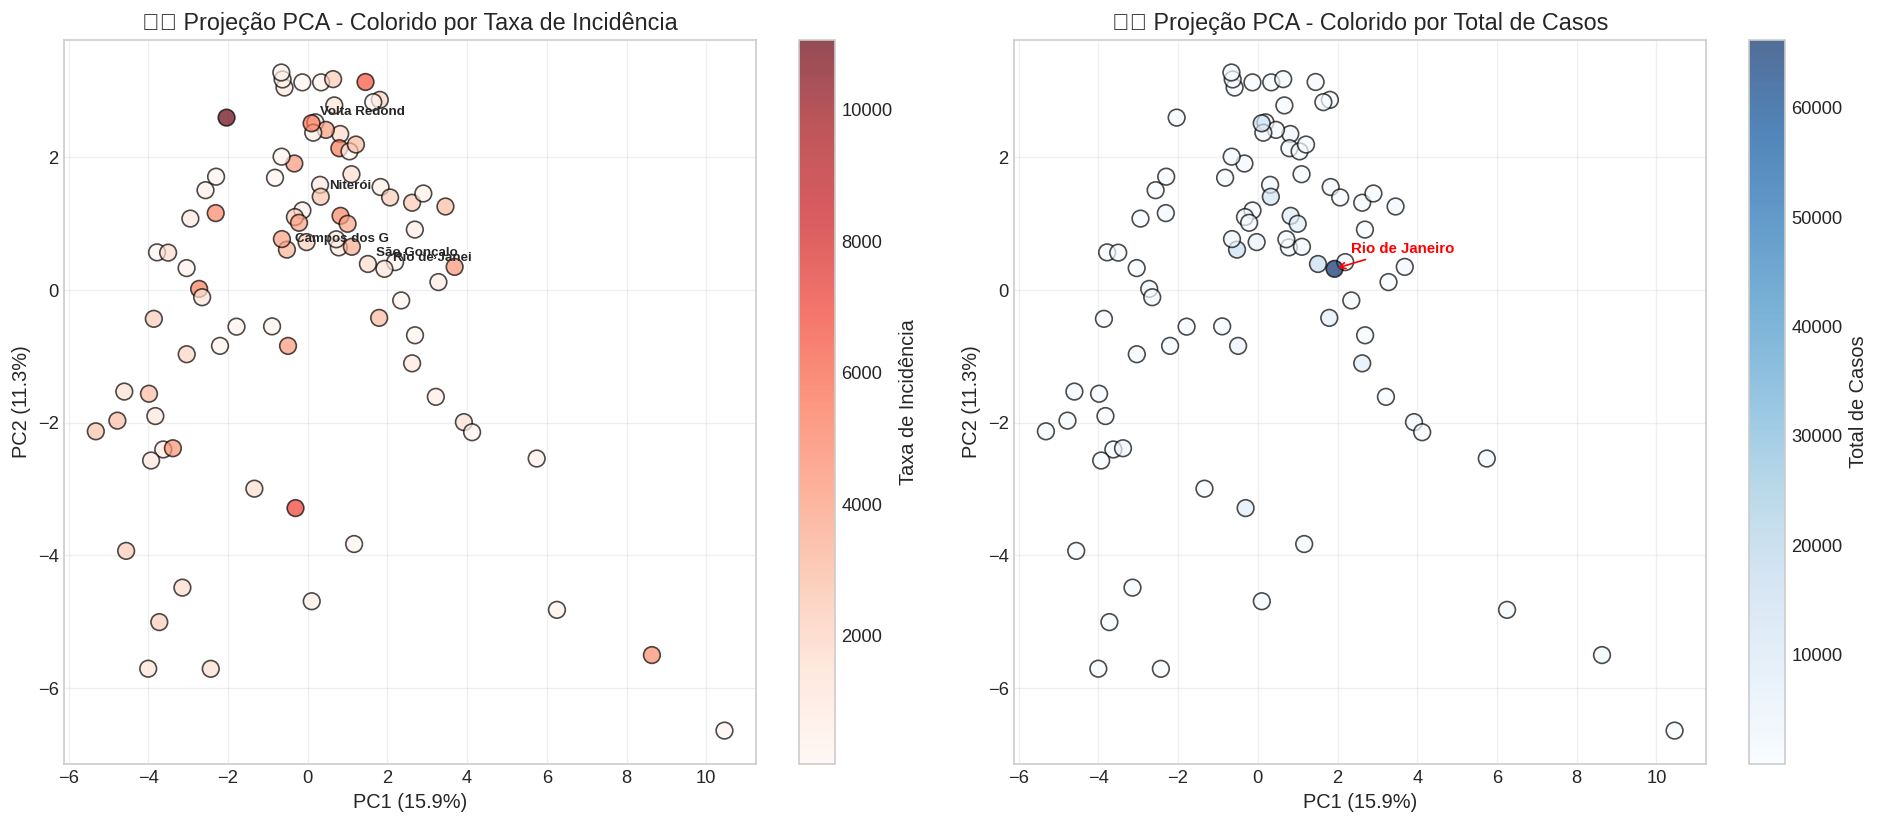


📊 RESULTADOS DA PROJEÇÃO PCA:
   • Variância capturada (PC1+PC2): 27.2%
   • Municípios mais à direita (PC1 alto): pico mais intenso no início do ano
   • Municípios mais acima (PC2 alto): padrão temporal diferenciado


In [15]:
# Projeção dos municípios em PC1 vs PC2
pca_2d = PCA(n_components=2)
data_pca = pca_2d.fit_transform(data_scaled)

# Adicionar taxas de incidência para colorir
incidence_for_color = [incidence_df[incidence_df['municipio'] == m]['taxa_incidencia'].values[0] 
                       if m in incidence_df['municipio'].values else 0 
                       for m in municipalities]

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot PC1 vs PC2 colorido por taxa de incidência
scatter = axes[0].scatter(data_pca[:, 0], data_pca[:, 1], 
                          c=incidence_for_color, cmap='Reds', 
                          s=100, alpha=0.7, edgecolor='black')
plt.colorbar(scatter, ax=axes[0], label='Taxa de Incidência')
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title('🗺️ Projeção PCA - Colorido por Taxa de Incidência')
axes[0].grid(True, alpha=0.3)

# Destacar municípios importantes
top_5_mun = [m for m, _ in top_10[:5]]
for i, mun in enumerate(municipalities):
    if mun in top_5_mun:
        axes[0].annotate(mun[:12], (data_pca[i, 0], data_pca[i, 1]), 
                        fontsize=8, fontweight='bold',
                        xytext=(5, 5), textcoords='offset points')

# Plot PC1 vs PC2 colorido por total de casos
cases_for_color = [totals[m] for m in municipalities]
scatter2 = axes[1].scatter(data_pca[:, 0], data_pca[:, 1], 
                           c=cases_for_color, cmap='Blues', 
                           s=100, alpha=0.7, edgecolor='black')
plt.colorbar(scatter2, ax=axes[1], label='Total de Casos')
axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
axes[1].set_title('🗺️ Projeção PCA - Colorido por Total de Casos')
axes[1].grid(True, alpha=0.3)

# Destacar Rio de Janeiro
if 'Rio de Janeiro' in municipalities:
    idx_rj = municipalities.index('Rio de Janeiro')
    axes[1].annotate('Rio de Janeiro', (data_pca[idx_rj, 0], data_pca[idx_rj, 1]), 
                    fontsize=9, fontweight='bold', color='red',
                    xytext=(10, 10), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.savefig('output/apresentacao_pca_projecao.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 RESULTADOS DA PROJEÇÃO PCA:")
print(f"   • Variância capturada (PC1+PC2): {(pca_2d.explained_variance_ratio_.sum())*100:.1f}%")
print(f"   • Municípios mais à direita (PC1 alto): pico mais intenso no início do ano")
print(f"   • Municípios mais acima (PC2 alto): padrão temporal diferenciado")

## 8. Análise de Clusterização

Aplicaremos três algoritmos de clusterização para identificar grupos de municípios com dinâmicas epidêmicas similares:

1. **K-Means**: Baseado em centroides, bom para clusters esféricos
2. **DBSCAN**: Baseado em densidade, detecta outliers automaticamente
3. **Hierárquico (Ward)**: Cria dendrograma, visualiza estrutura multinível

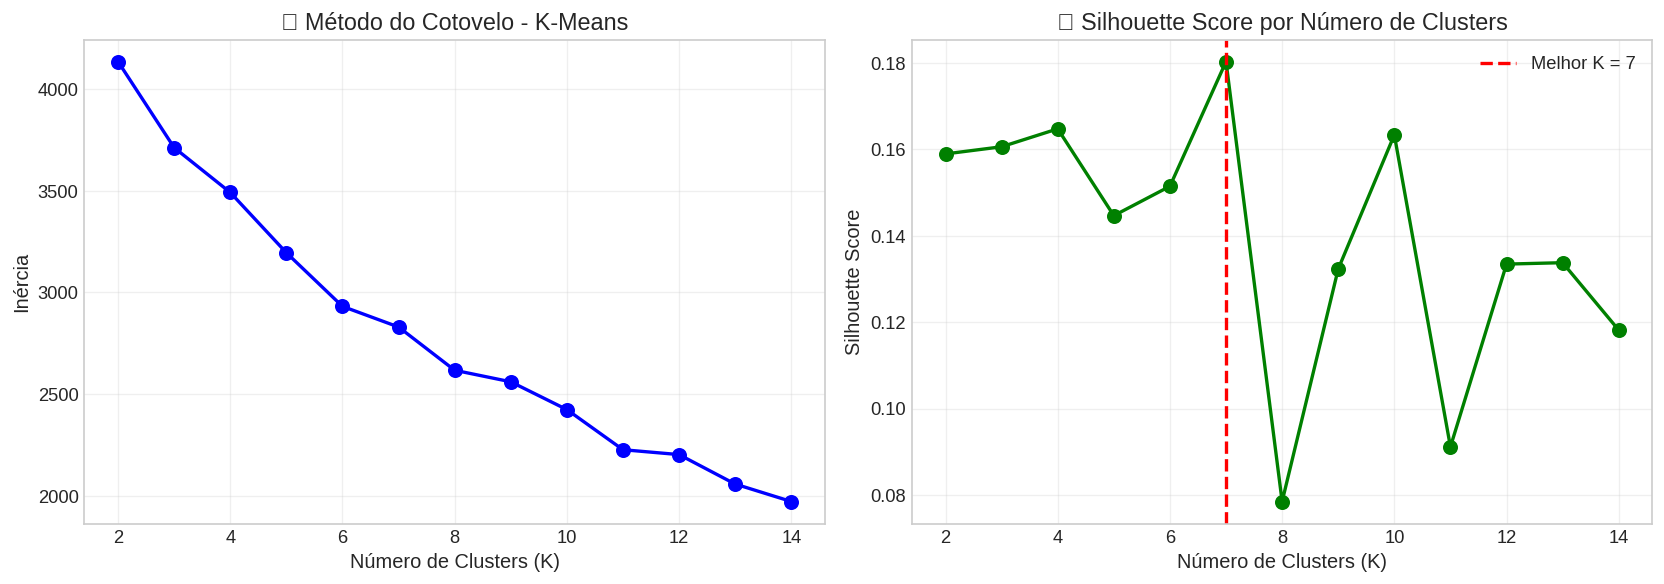


✅ Melhor número de clusters (K-Means): 7
   Silhouette Score: 0.1803


In [16]:
# Método do Cotovelo para K-Means
inertias = []
silhouettes = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(data_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow method
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (K)')
axes[0].set_ylabel('Inércia')
axes[0].set_title('📐 Método do Cotovelo - K-Means')
axes[0].grid(True, alpha=0.3)

# Silhouette score
axes[1].plot(K_range, silhouettes, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Número de Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('📊 Silhouette Score por Número de Clusters')
axes[1].grid(True, alpha=0.3)

# Marcar o melhor
best_k = K_range[np.argmax(silhouettes)]
axes[1].axvline(x=best_k, color='red', linestyle='--', linewidth=2, label=f'Melhor K = {best_k}')
axes[1].legend()

plt.tight_layout()
plt.savefig('output/apresentacao_kmeans_avaliacao.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Melhor número de clusters (K-Means): {best_k}")
print(f"   Silhouette Score: {max(silhouettes):.4f}")

In [17]:
# Aplicar os três algoritmos de clusterização
optimal_k = best_k

# K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(data_scaled)

# DBSCAN
dbscan = DBSCAN(eps=2.5, min_samples=3)
dbscan_labels = dbscan.fit_predict(data_scaled)

# Hierárquico
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hier_labels = hierarchical.fit_predict(data_scaled)

# Métricas
print("=" * 70)
print("📊 COMPARAÇÃO DOS ALGORITMOS DE CLUSTERIZAÇÃO")
print("=" * 70)

for name, labels in [("K-Means", kmeans_labels), ("DBSCAN", dbscan_labels), ("Hierárquico", hier_labels)]:
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    if n_clusters > 1:
        sil = silhouette_score(data_scaled, labels)
        cal = calinski_harabasz_score(data_scaled, labels)
    else:
        sil, cal = 0, 0
    
    print(f"\n{name}:")
    print(f"   Clusters: {n_clusters}")
    if n_noise > 0:
        print(f"   Ruído/Outliers: {n_noise}")
    print(f"   Silhouette Score: {sil:.4f}")
    print(f"   Calinski-Harabasz: {cal:.1f}")

📊 COMPARAÇÃO DOS ALGORITMOS DE CLUSTERIZAÇÃO

K-Means:
   Clusters: 7
   Silhouette Score: 0.1803
   Calinski-Harabasz: 9.0

DBSCAN:
   Clusters: 1
   Ruído/Outliers: 76
   Silhouette Score: 0.0000
   Calinski-Harabasz: 0.0

Hierárquico:
   Clusters: 7
   Silhouette Score: 0.1471
   Calinski-Harabasz: 9.3


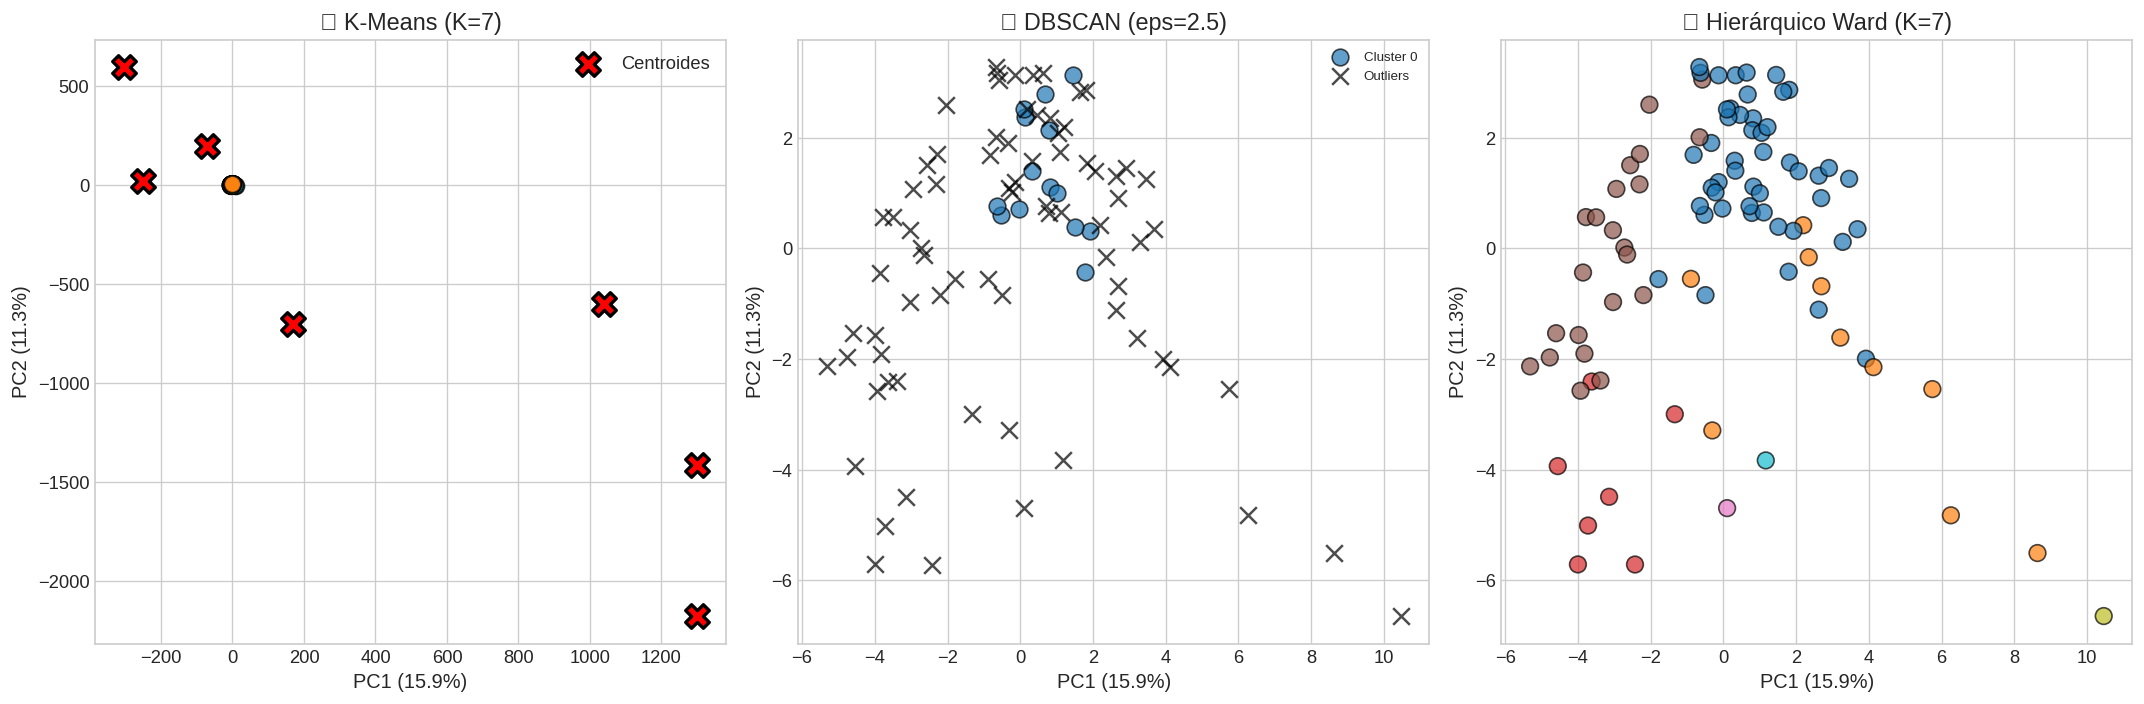

In [18]:
# Visualização dos clusters em PCA
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# K-Means
scatter1 = axes[0].scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels, 
                           cmap='tab10', s=100, alpha=0.7, edgecolor='black')
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title(f'🎯 K-Means (K={optimal_k})')

# Centroides
centroids_pca = pca_2d.transform(scaler.transform(kmeans.cluster_centers_))
axes[0].scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', 
               marker='X', s=200, edgecolor='black', linewidth=2, label='Centroides')
axes[0].legend()

# DBSCAN
unique_labels = set(dbscan_labels)
colors_db = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors_db):
    if k == -1:
        col = 'black'
        marker = 'x'
        label = 'Outliers'
    else:
        marker = 'o'
        label = f'Cluster {k}'
    mask = dbscan_labels == k
    axes[1].scatter(data_pca[mask, 0], data_pca[mask, 1], c=[col], 
                   marker=marker, s=100, alpha=0.7, edgecolor='black', label=label)
axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
axes[1].set_title(f'🔍 DBSCAN (eps=2.5)')
axes[1].legend(fontsize=8)

# Hierárquico
scatter3 = axes[2].scatter(data_pca[:, 0], data_pca[:, 1], c=hier_labels, 
                           cmap='tab10', s=100, alpha=0.7, edgecolor='black')
axes[2].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
axes[2].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
axes[2].set_title(f'🌳 Hierárquico Ward (K={optimal_k})')

plt.tight_layout()
plt.savefig('output/apresentacao_clusters_pca.png', dpi=150, bbox_inches='tight')
plt.show()

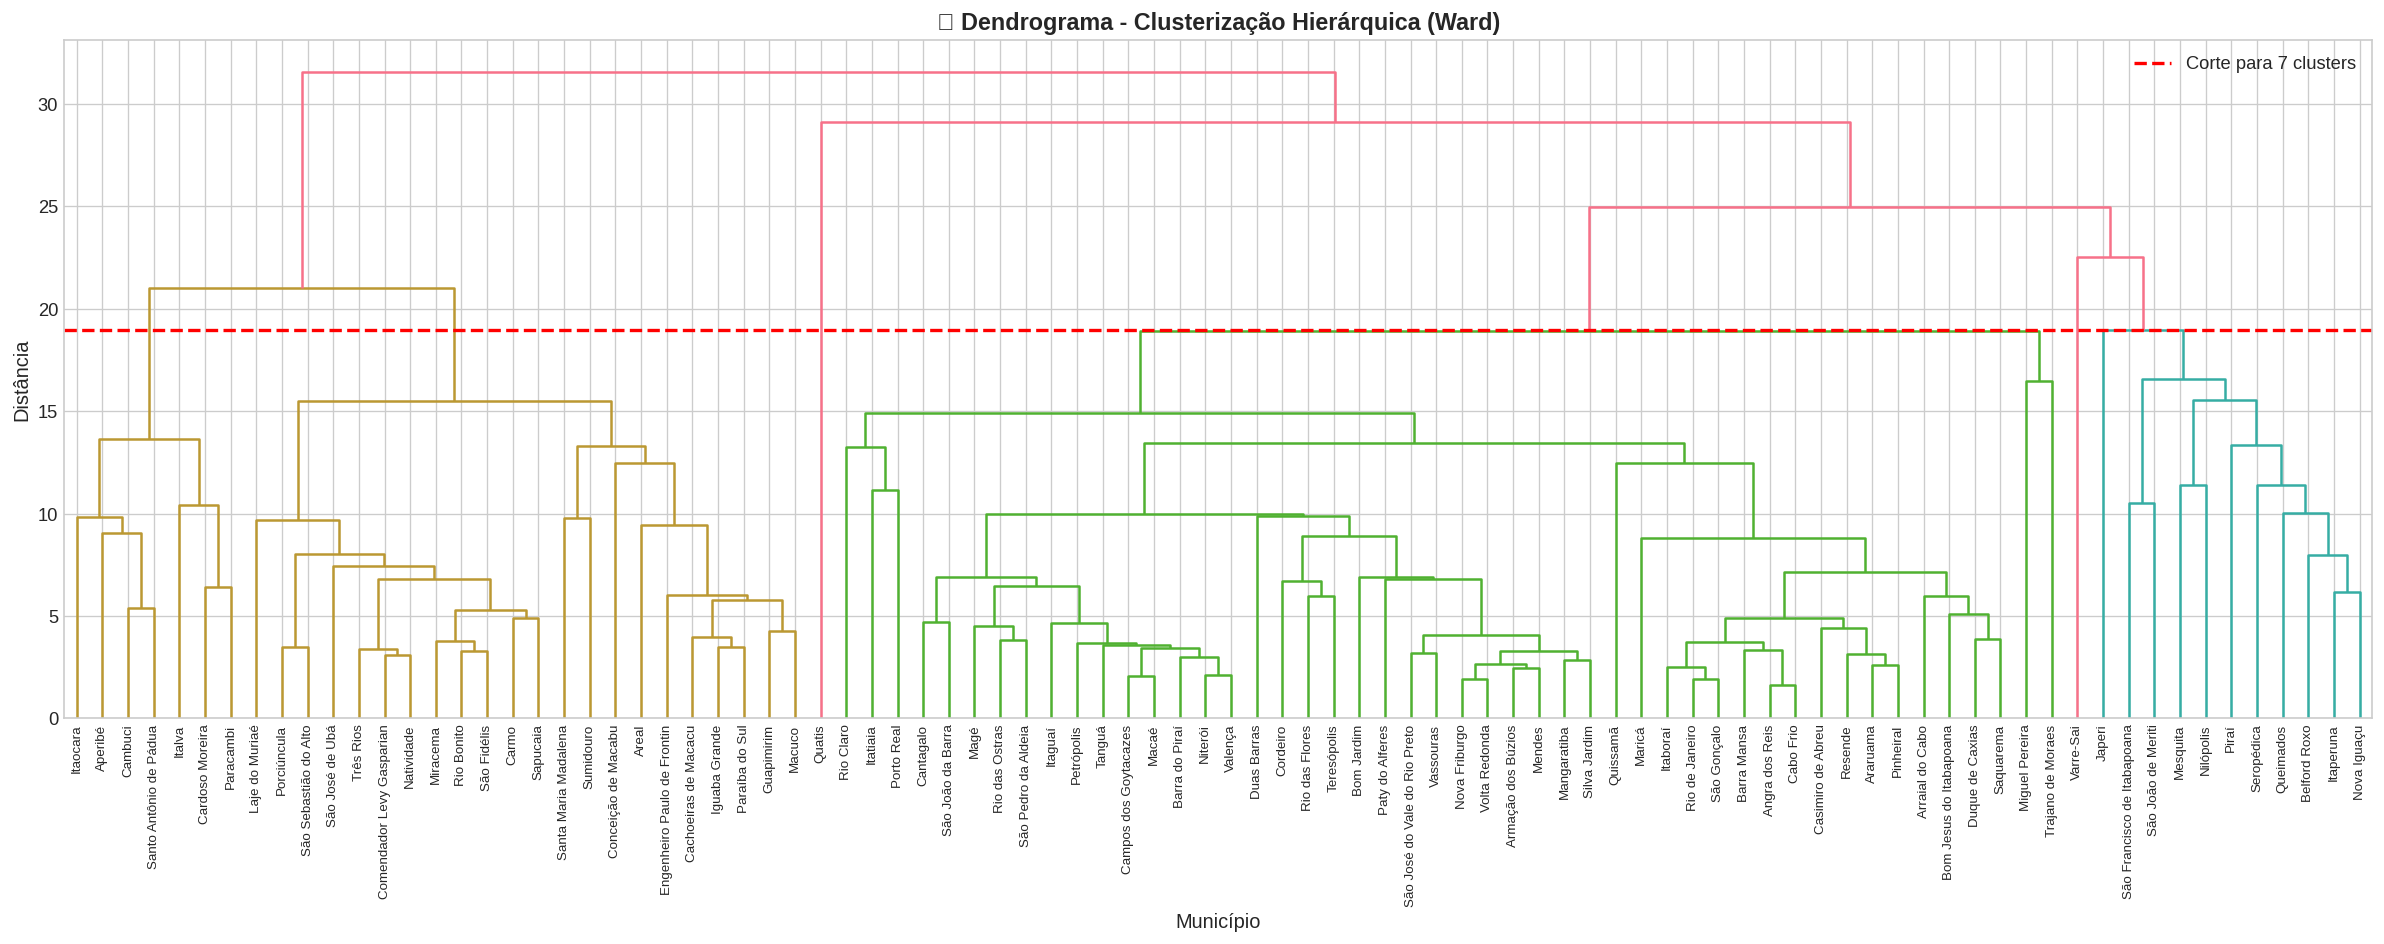


📊 O dendrograma revela a estrutura hierárquica dos municípios
   Municípios próximos na árvore têm curvas epidêmicas mais similares


In [19]:
# Dendrograma da clusterização hierárquica
fig, ax = plt.subplots(figsize=(20, 8))

# Calcular linkage
linkage_matrix = linkage(data_scaled, method='ward')

# Plotar dendrograma
dendrogram(linkage_matrix, labels=municipalities, leaf_rotation=90, leaf_font_size=8, ax=ax)
ax.set_title('🌳 Dendrograma - Clusterização Hierárquica (Ward)', fontsize=14, fontweight='bold')
ax.set_xlabel('Município')
ax.set_ylabel('Distância')

# Linha de corte para K clusters
cut_height = linkage_matrix[-(optimal_k-1), 2]
ax.axhline(y=cut_height, color='red', linestyle='--', linewidth=2, label=f'Corte para {optimal_k} clusters')
ax.legend()

plt.tight_layout()
plt.savefig('output/apresentacao_dendrograma.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 O dendrograma revela a estrutura hierárquica dos municípios")
print("   Municípios próximos na árvore têm curvas epidêmicas mais similares")

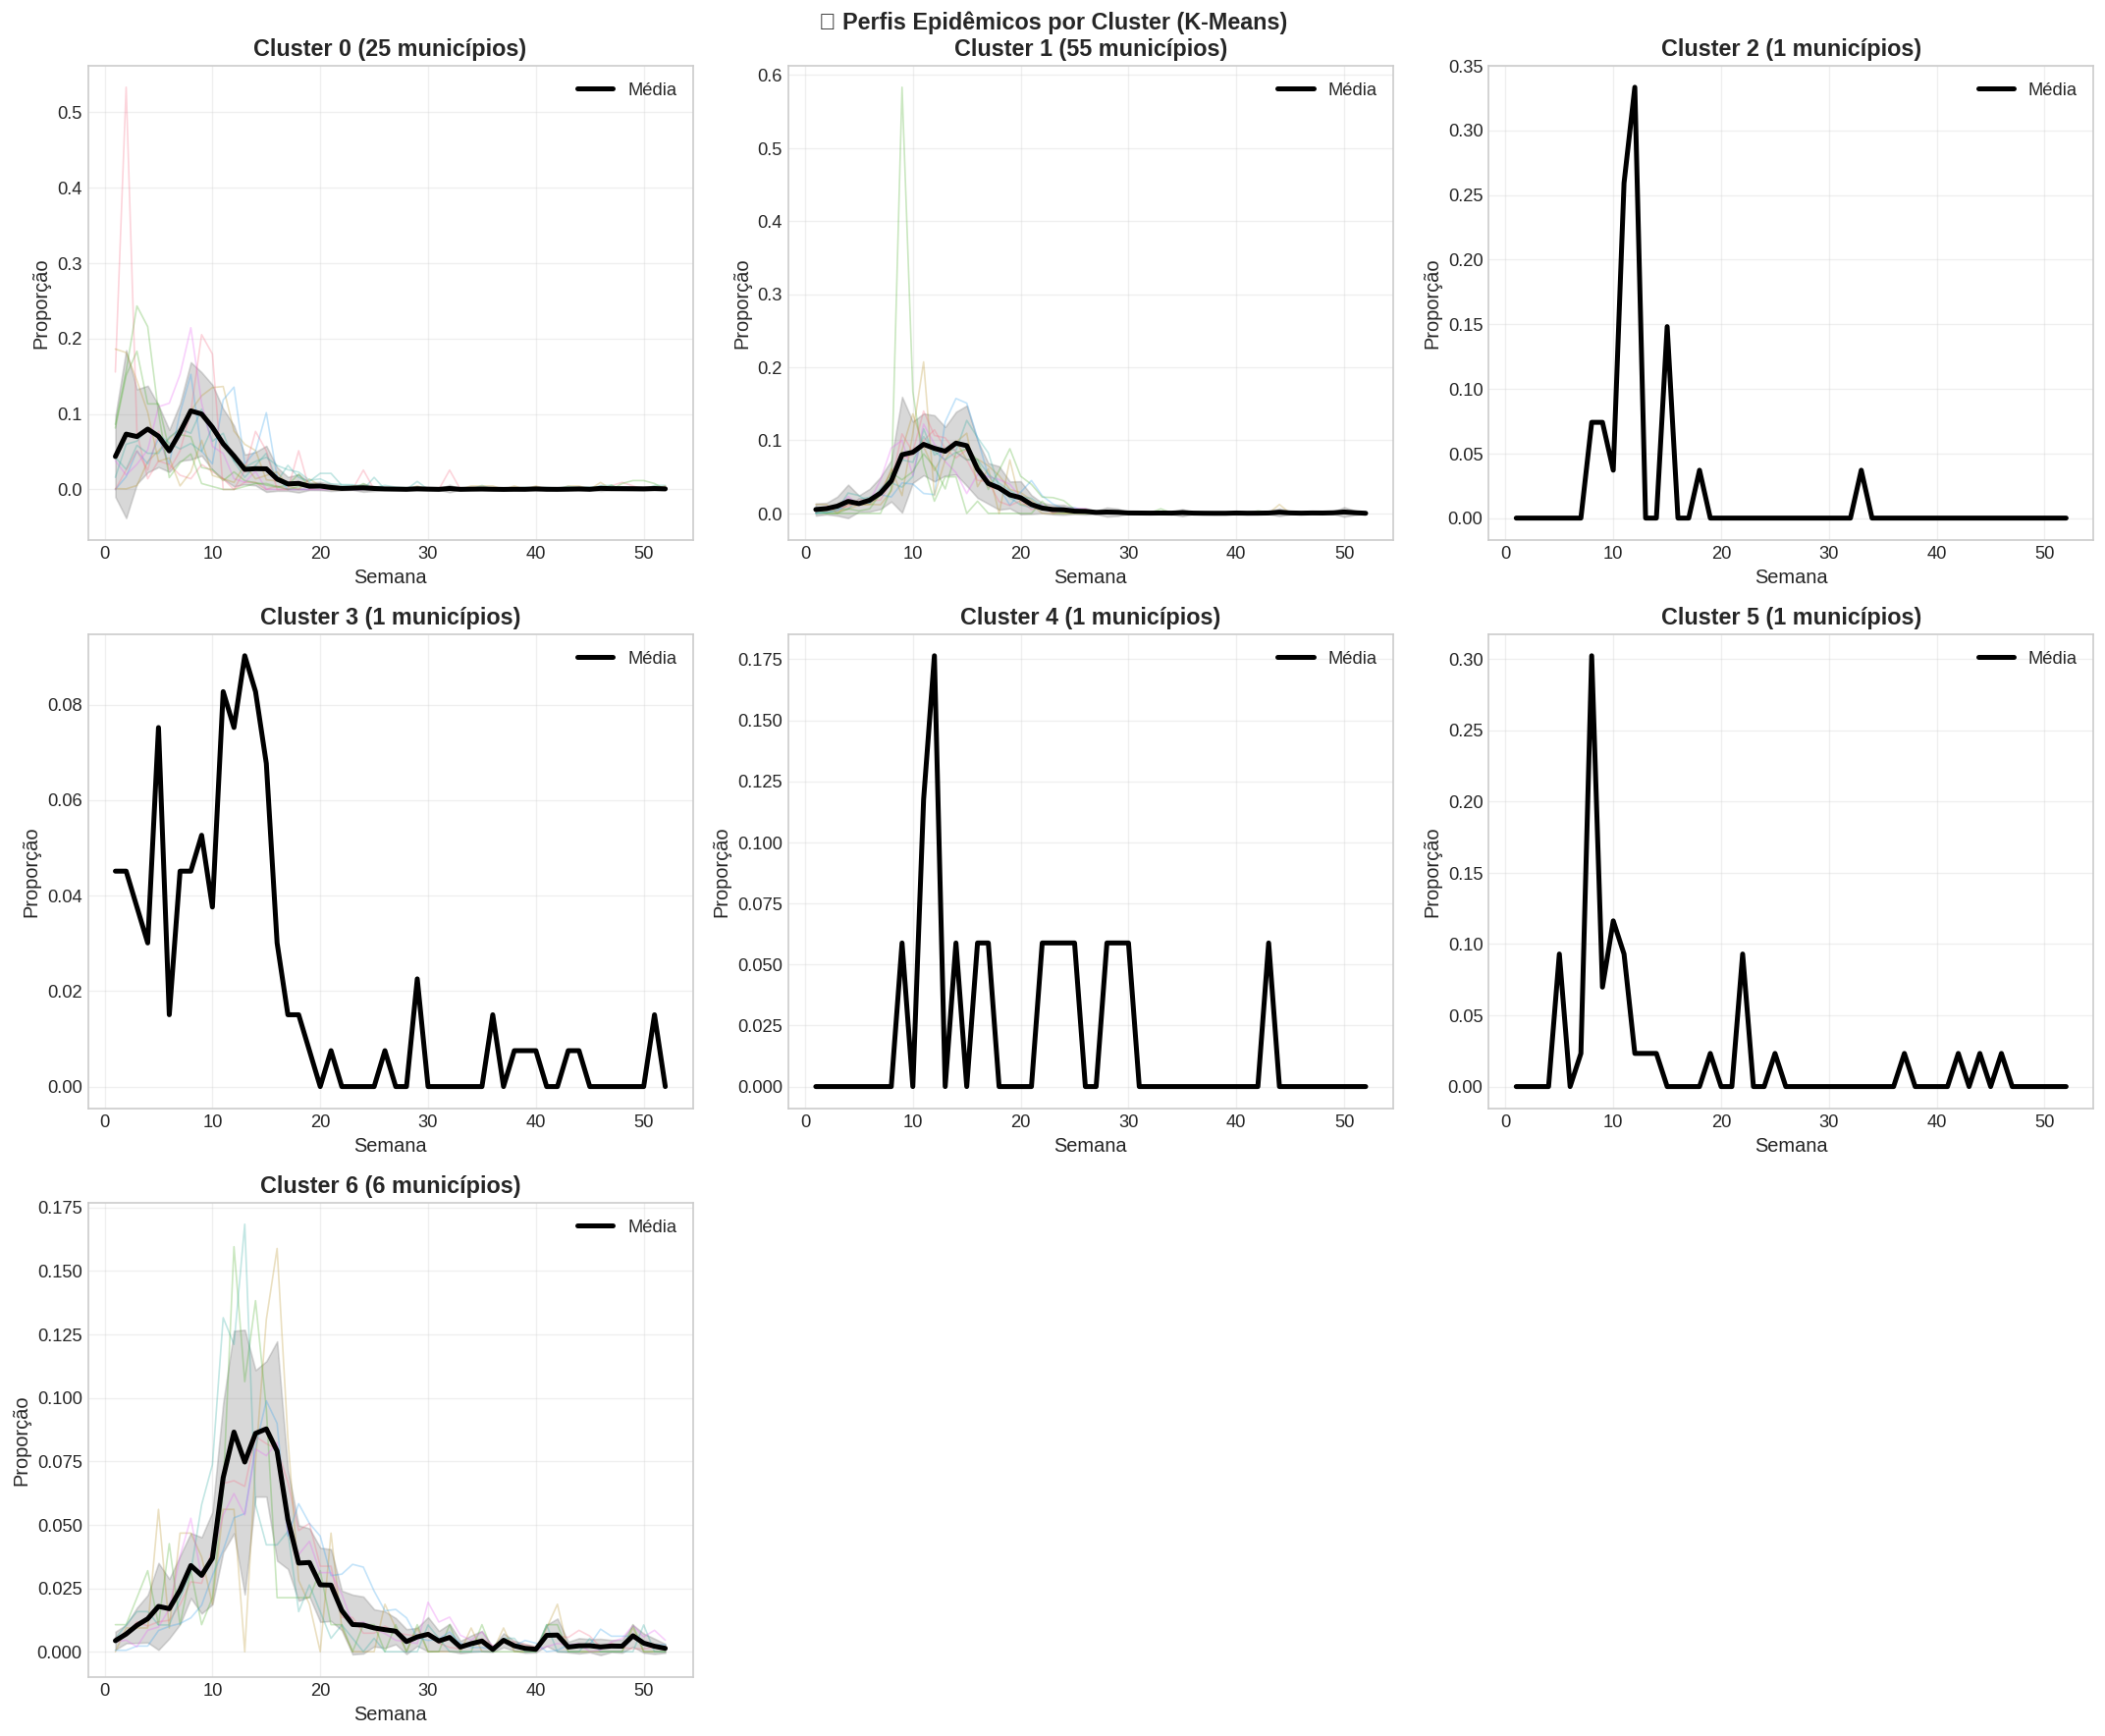


📋 MUNICÍPIOS POR CLUSTER:

🔷 Cluster 0 (25 municípios):
   • Aperibé
   • Cachoeiras de Macacu
   • Cambuci
   • Cardoso Moreira
   • Carmo
   • Comendador Levy Gasparian
   • Conceição de Macabu
   • Italva
   ... e mais 17 municípios

🔷 Cluster 1 (55 municípios):
   • Angra dos Reis
   • Araruama
   • Areal
   • Armação dos Búzios
   • Arraial do Cabo
   • Barra Mansa
   • Barra do Piraí
   • Bom Jardim
   ... e mais 47 municípios

🔷 Cluster 2 (1 municípios):
   • Trajano de Moraes

🔷 Cluster 3 (1 municípios):
   • Japeri

🔷 Cluster 4 (1 municípios):
   • Quatis

🔷 Cluster 5 (1 municípios):
   • Varre-Sai

🔷 Cluster 6 (6 municípios):
   • Belford Roxo
   • Mesquita
   • Nilópolis
   • Queimados
   • São Francisco de Itabapoana
   • São João de Meriti


In [20]:
# Perfil dos clusters (K-Means)
n_rows = (optimal_k + 2) // 3  # Calcula número de linhas necessárias
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 5*n_rows))
axes = axes.flatten()

cluster_profiles = {}
for cluster in range(optimal_k):
    mask = kmeans_labels == cluster
    cluster_data = data_matrix[mask]
    cluster_muns = [m for m, c in zip(municipalities, kmeans_labels) if c == cluster]
    
    cluster_profiles[cluster] = {
        'n_municipios': len(cluster_muns),
        'municipios': cluster_muns,
        'media': cluster_data.mean(axis=0),
        'std': cluster_data.std(axis=0)
    }
    
    # Plotar perfil
    ax = axes[cluster]
    weeks = np.arange(1, 53)
    
    # Curvas individuais
    for i, mun in enumerate(cluster_muns[:10]):  # Máximo 10 curvas
        ax.plot(weeks, normalized_series[mun], alpha=0.3, linewidth=1)
    
    # Média do cluster
    ax.plot(weeks, cluster_profiles[cluster]['media'], 'k-', linewidth=3, label='Média')
    ax.fill_between(weeks, 
                   cluster_profiles[cluster]['media'] - cluster_profiles[cluster]['std'],
                   cluster_profiles[cluster]['media'] + cluster_profiles[cluster]['std'],
                   alpha=0.3, color='gray')
    
    ax.set_xlabel('Semana')
    ax.set_ylabel('Proporção')
    ax.set_title(f'Cluster {cluster} ({len(cluster_muns)} municípios)', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Ocultar subplots extras
for i in range(optimal_k, len(axes)):
    axes[i].axis('off')

plt.suptitle('📊 Perfis Epidêmicos por Cluster (K-Means)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('output/apresentacao_perfis_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

# Listar municípios por cluster
print("\n📋 MUNICÍPIOS POR CLUSTER:")
for cluster in range(optimal_k):
    muns = cluster_profiles[cluster]['municipios']
    print(f"\n🔷 Cluster {cluster} ({len(muns)} municípios):")
    for mun in muns[:8]:
        print(f"   • {mun}")
    if len(muns) > 8:
        print(f"   ... e mais {len(muns) - 8} municípios")

## 9. Complexos Simpliciais

### Topological Data Analysis (TDA)

Um **complexo simplicial** é uma estrutura topológica que generaliza grafos:

| Dimensão | Nome | Descrição |
|----------|------|-----------|
| 0 | Vértice | Um ponto (município) |
| 1 | Aresta | Conexão entre 2 municípios (distância < limiar) |
| 2 | Triângulo | Trio de municípios todos conectados |
| 3 | Tetraedro | Quatro municípios todos conectados |

### Construção
Dois municípios são conectados se sua distância é menor que um **limiar (ε)**.

📐 ANÁLISE DE LIMIARES - COMPLEXO SIMPLICIAL
  limiar  arestas  triangulos  tetraedros
0.452359      401        1831        5744
0.580434      801        6066       33976
0.686108     1202       11999       89523
0.791258     1602       19761      178566
0.901763     2002       29807      323687
1.020602     2403       41333      513491
1.137348     2803       55014      780456
1.257769     3204       71066     1133798
1.404162     3604       91622     1683988


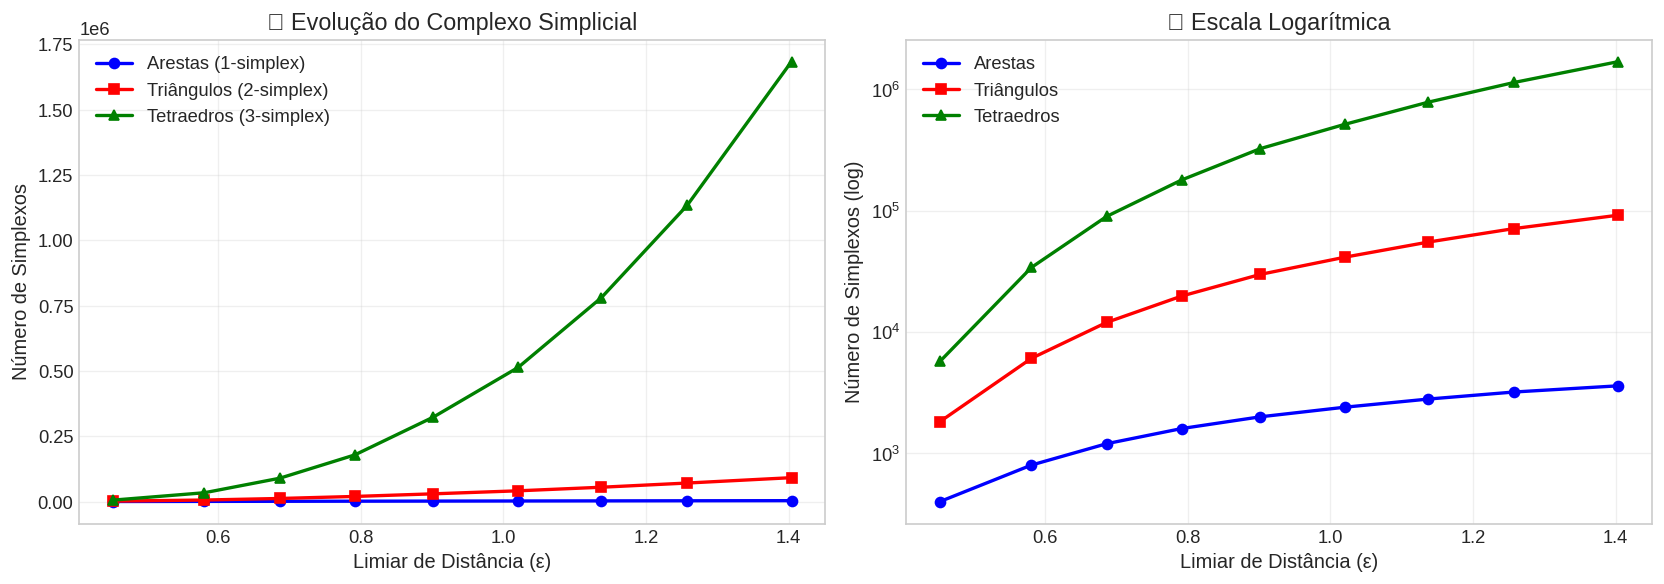

In [21]:
# Análise de limiares para o complexo simplicial
thresholds = np.percentile(dist_L1, [10, 20, 30, 40, 50, 60, 70, 80, 90])

threshold_results = []
for threshold in thresholds:
    complex_obj = create_simplicial_complex_from_distance_matrix(
        MD1, mun_list, threshold, max_dimension=3
    )
    counts = complex_obj.count_simplices()
    threshold_results.append({
        'limiar': threshold,
        'arestas': counts.get(1, 0),
        'triangulos': counts.get(2, 0),
        'tetraedros': counts.get(3, 0)
    })

threshold_df = pd.DataFrame(threshold_results)

print("=" * 70)
print("📐 ANÁLISE DE LIMIARES - COMPLEXO SIMPLICIAL")
print("=" * 70)
print(threshold_df.to_string(index=False))

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Evolução dos simplexos
axes[0].plot(threshold_df['limiar'], threshold_df['arestas'], 'bo-', linewidth=2, label='Arestas (1-simplex)')
axes[0].plot(threshold_df['limiar'], threshold_df['triangulos'], 'rs-', linewidth=2, label='Triângulos (2-simplex)')
axes[0].plot(threshold_df['limiar'], threshold_df['tetraedros'], 'g^-', linewidth=2, label='Tetraedros (3-simplex)')
axes[0].set_xlabel('Limiar de Distância (ε)')
axes[0].set_ylabel('Número de Simplexos')
axes[0].set_title('📈 Evolução do Complexo Simplicial')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Escala log
axes[1].semilogy(threshold_df['limiar'], threshold_df['arestas'] + 1, 'bo-', linewidth=2, label='Arestas')
axes[1].semilogy(threshold_df['limiar'], threshold_df['triangulos'] + 1, 'rs-', linewidth=2, label='Triângulos')
axes[1].semilogy(threshold_df['limiar'], threshold_df['tetraedros'] + 1, 'g^-', linewidth=2, label='Tetraedros')
axes[1].set_xlabel('Limiar de Distância (ε)')
axes[1].set_ylabel('Número de Simplexos (log)')
axes[1].set_title('📈 Escala Logarítmica')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/apresentacao_simplicial_limiares.png', dpi=150, bbox_inches='tight')
plt.show()


📐 Construindo complexo com limiar = 0.6861 (percentil 30)



🔷 Estrutura do Complexo Simplicial:
   0-simplexos (vértices): 90
   1-simplexos (arestas): 1202
   2-simplexos (triângulos): 11999
   3-simplexos (tetraedros): 89523

🎯 Clusters identificados pelo complexo: 10


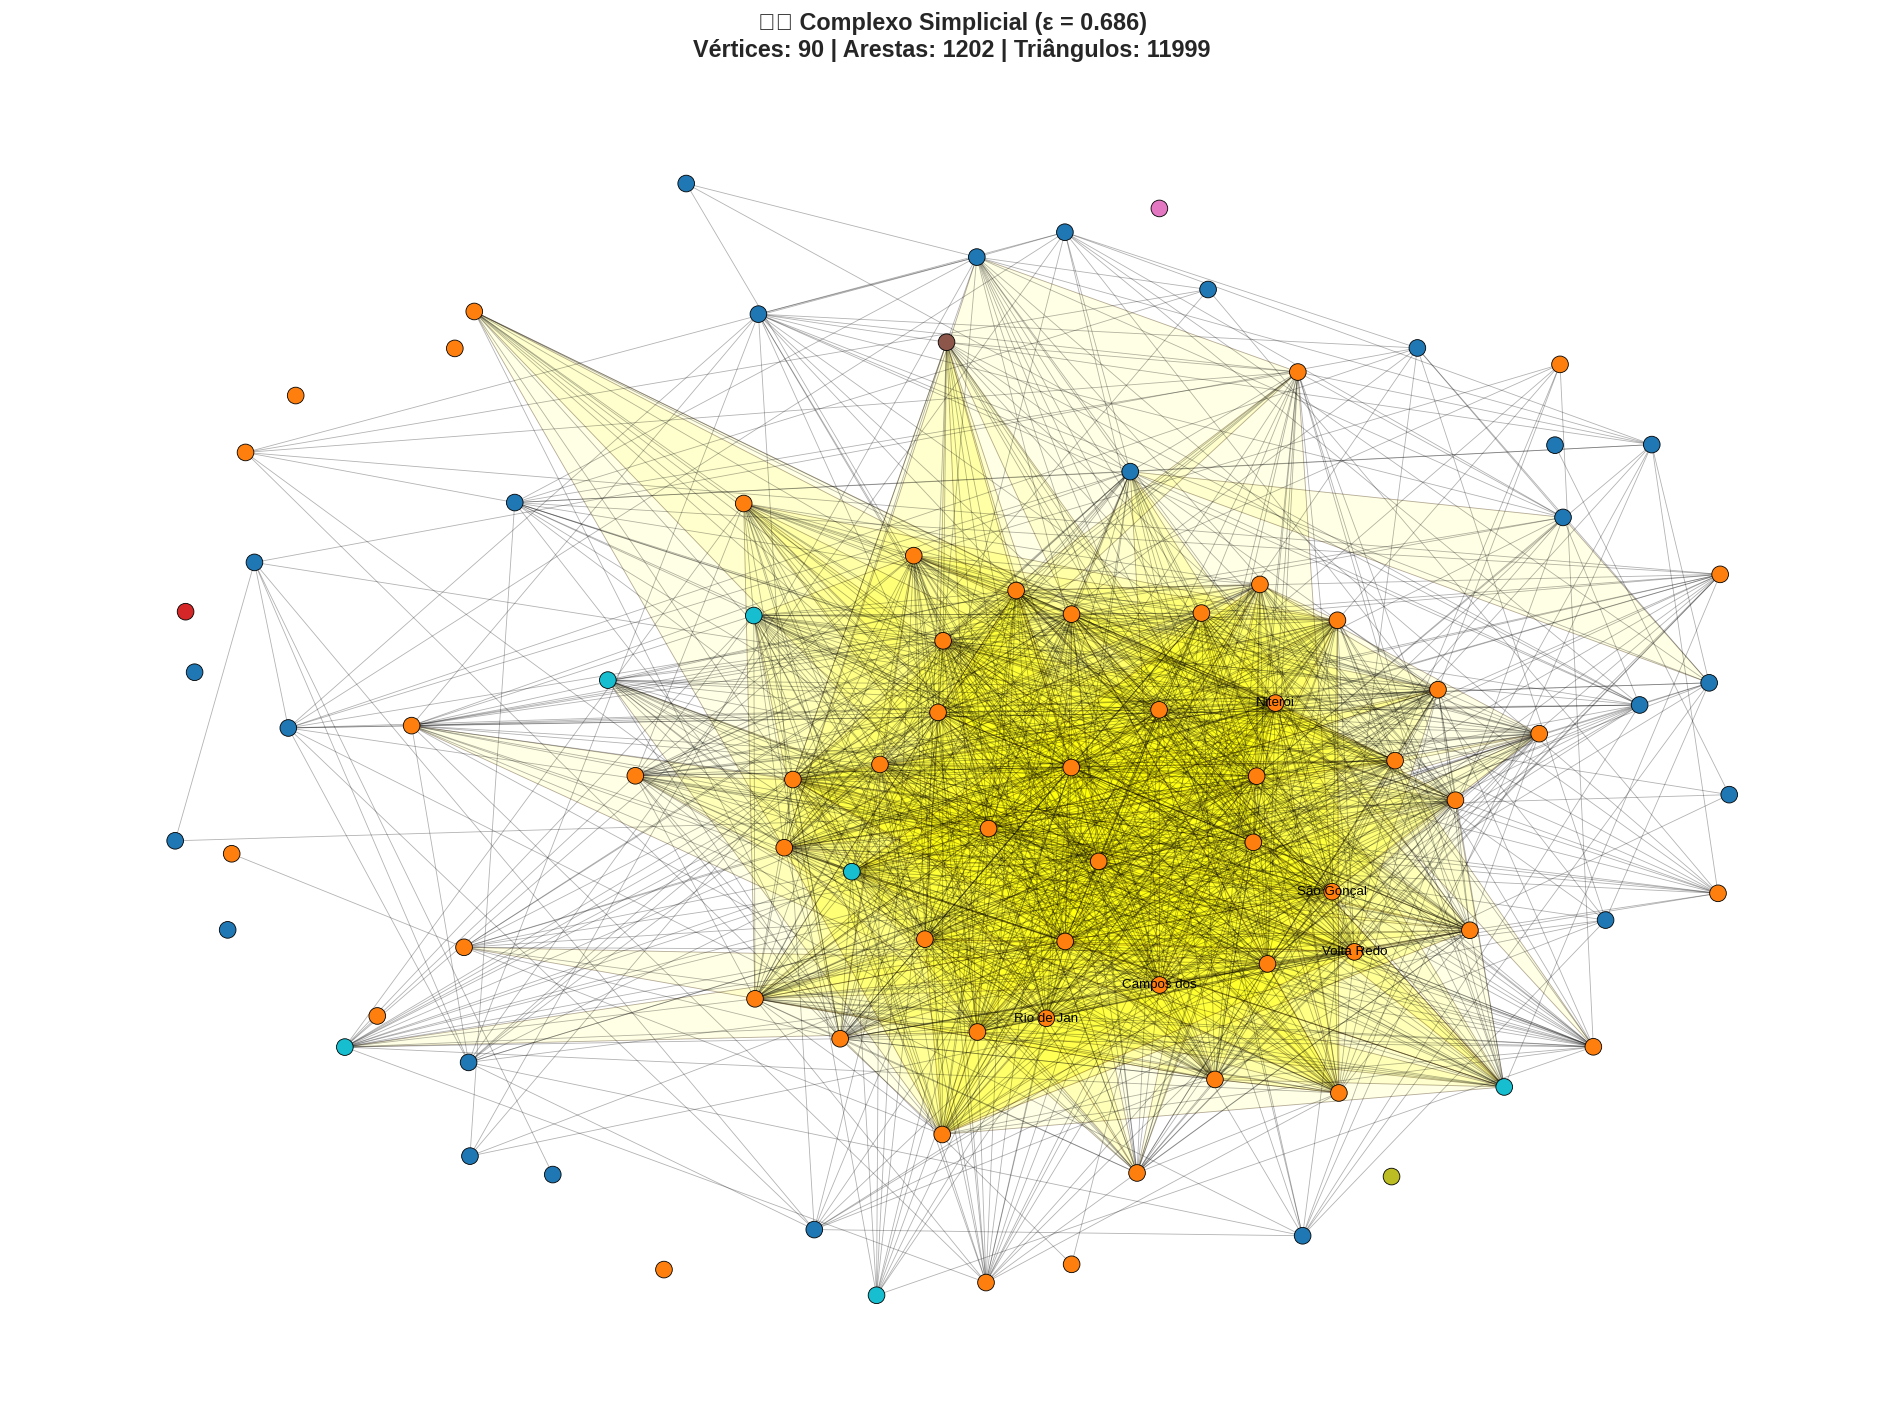

In [22]:
# Construir complexo com limiar específico (percentil 30)
threshold = np.percentile(dist_L1, 30)
print(f"\n📐 Construindo complexo com limiar = {threshold:.4f} (percentil 30)")

complex_obj = create_simplicial_complex_from_distance_matrix(
    MD1, mun_list, threshold, max_dimension=3
)
counts = complex_obj.count_simplices()

print(f"\n🔷 Estrutura do Complexo Simplicial:")
print(f"   0-simplexos (vértices): {counts.get(0, 0)}")
print(f"   1-simplexos (arestas): {counts.get(1, 0)}")
print(f"   2-simplexos (triângulos): {counts.get(2, 0)}")
print(f"   3-simplexos (tetraedros): {counts.get(3, 0)}")

# Identificar clusters pelo complexo
simplicial_clusters = identify_clusters(MD1, mun_list, threshold)
print(f"\n🎯 Clusters identificados pelo complexo: {len(simplicial_clusters)}")

# Visualização do complexo como grafo
import networkx as nx

G = nx.Graph()
G.add_nodes_from(range(len(mun_list)))

# Adicionar arestas
for edge in complex_obj.get_simplices(1):
    G.add_edge(edge[0], edge[1])

fig, ax = plt.subplots(figsize=(16, 12))

# Layout
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Desenhar triângulos
triangles = complex_obj.get_simplices(2)
for triangle in list(triangles)[:100]:  # Limitar para performance
    triangle = list(triangle)
    triangle_coords = [pos[v] for v in triangle]
    triangle_coords.append(triangle_coords[0])
    xs, ys = zip(*triangle_coords)
    ax.fill(xs, ys, alpha=0.1, color='yellow', edgecolor='orange', linewidth=0.5)

# Desenhar grafo
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5, ax=ax)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=kmeans_labels, 
                       cmap='tab10', edgecolors='black', linewidths=0.5, ax=ax)

# Rótulos para alguns nós importantes
labels_dict = {i: mun_list[i][:10] for i in range(len(mun_list)) if mun_list[i] in top_5_mun}
nx.draw_networkx_labels(G, pos, labels_dict, font_size=8, ax=ax)

ax.set_title(f'🕸️ Complexo Simplicial (ε = {threshold:.3f})\nVértices: {counts.get(0,0)} | Arestas: {counts.get(1,0)} | Triângulos: {counts.get(2,0)}',
            fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.savefig('output/apresentacao_complexo_simplicial.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Integração: PCA + Clusters + Complexo Simplicial

### Análise Combinada
Combinaremos os insights das diferentes análises para uma visão holística dos padrões epidemiológicos.

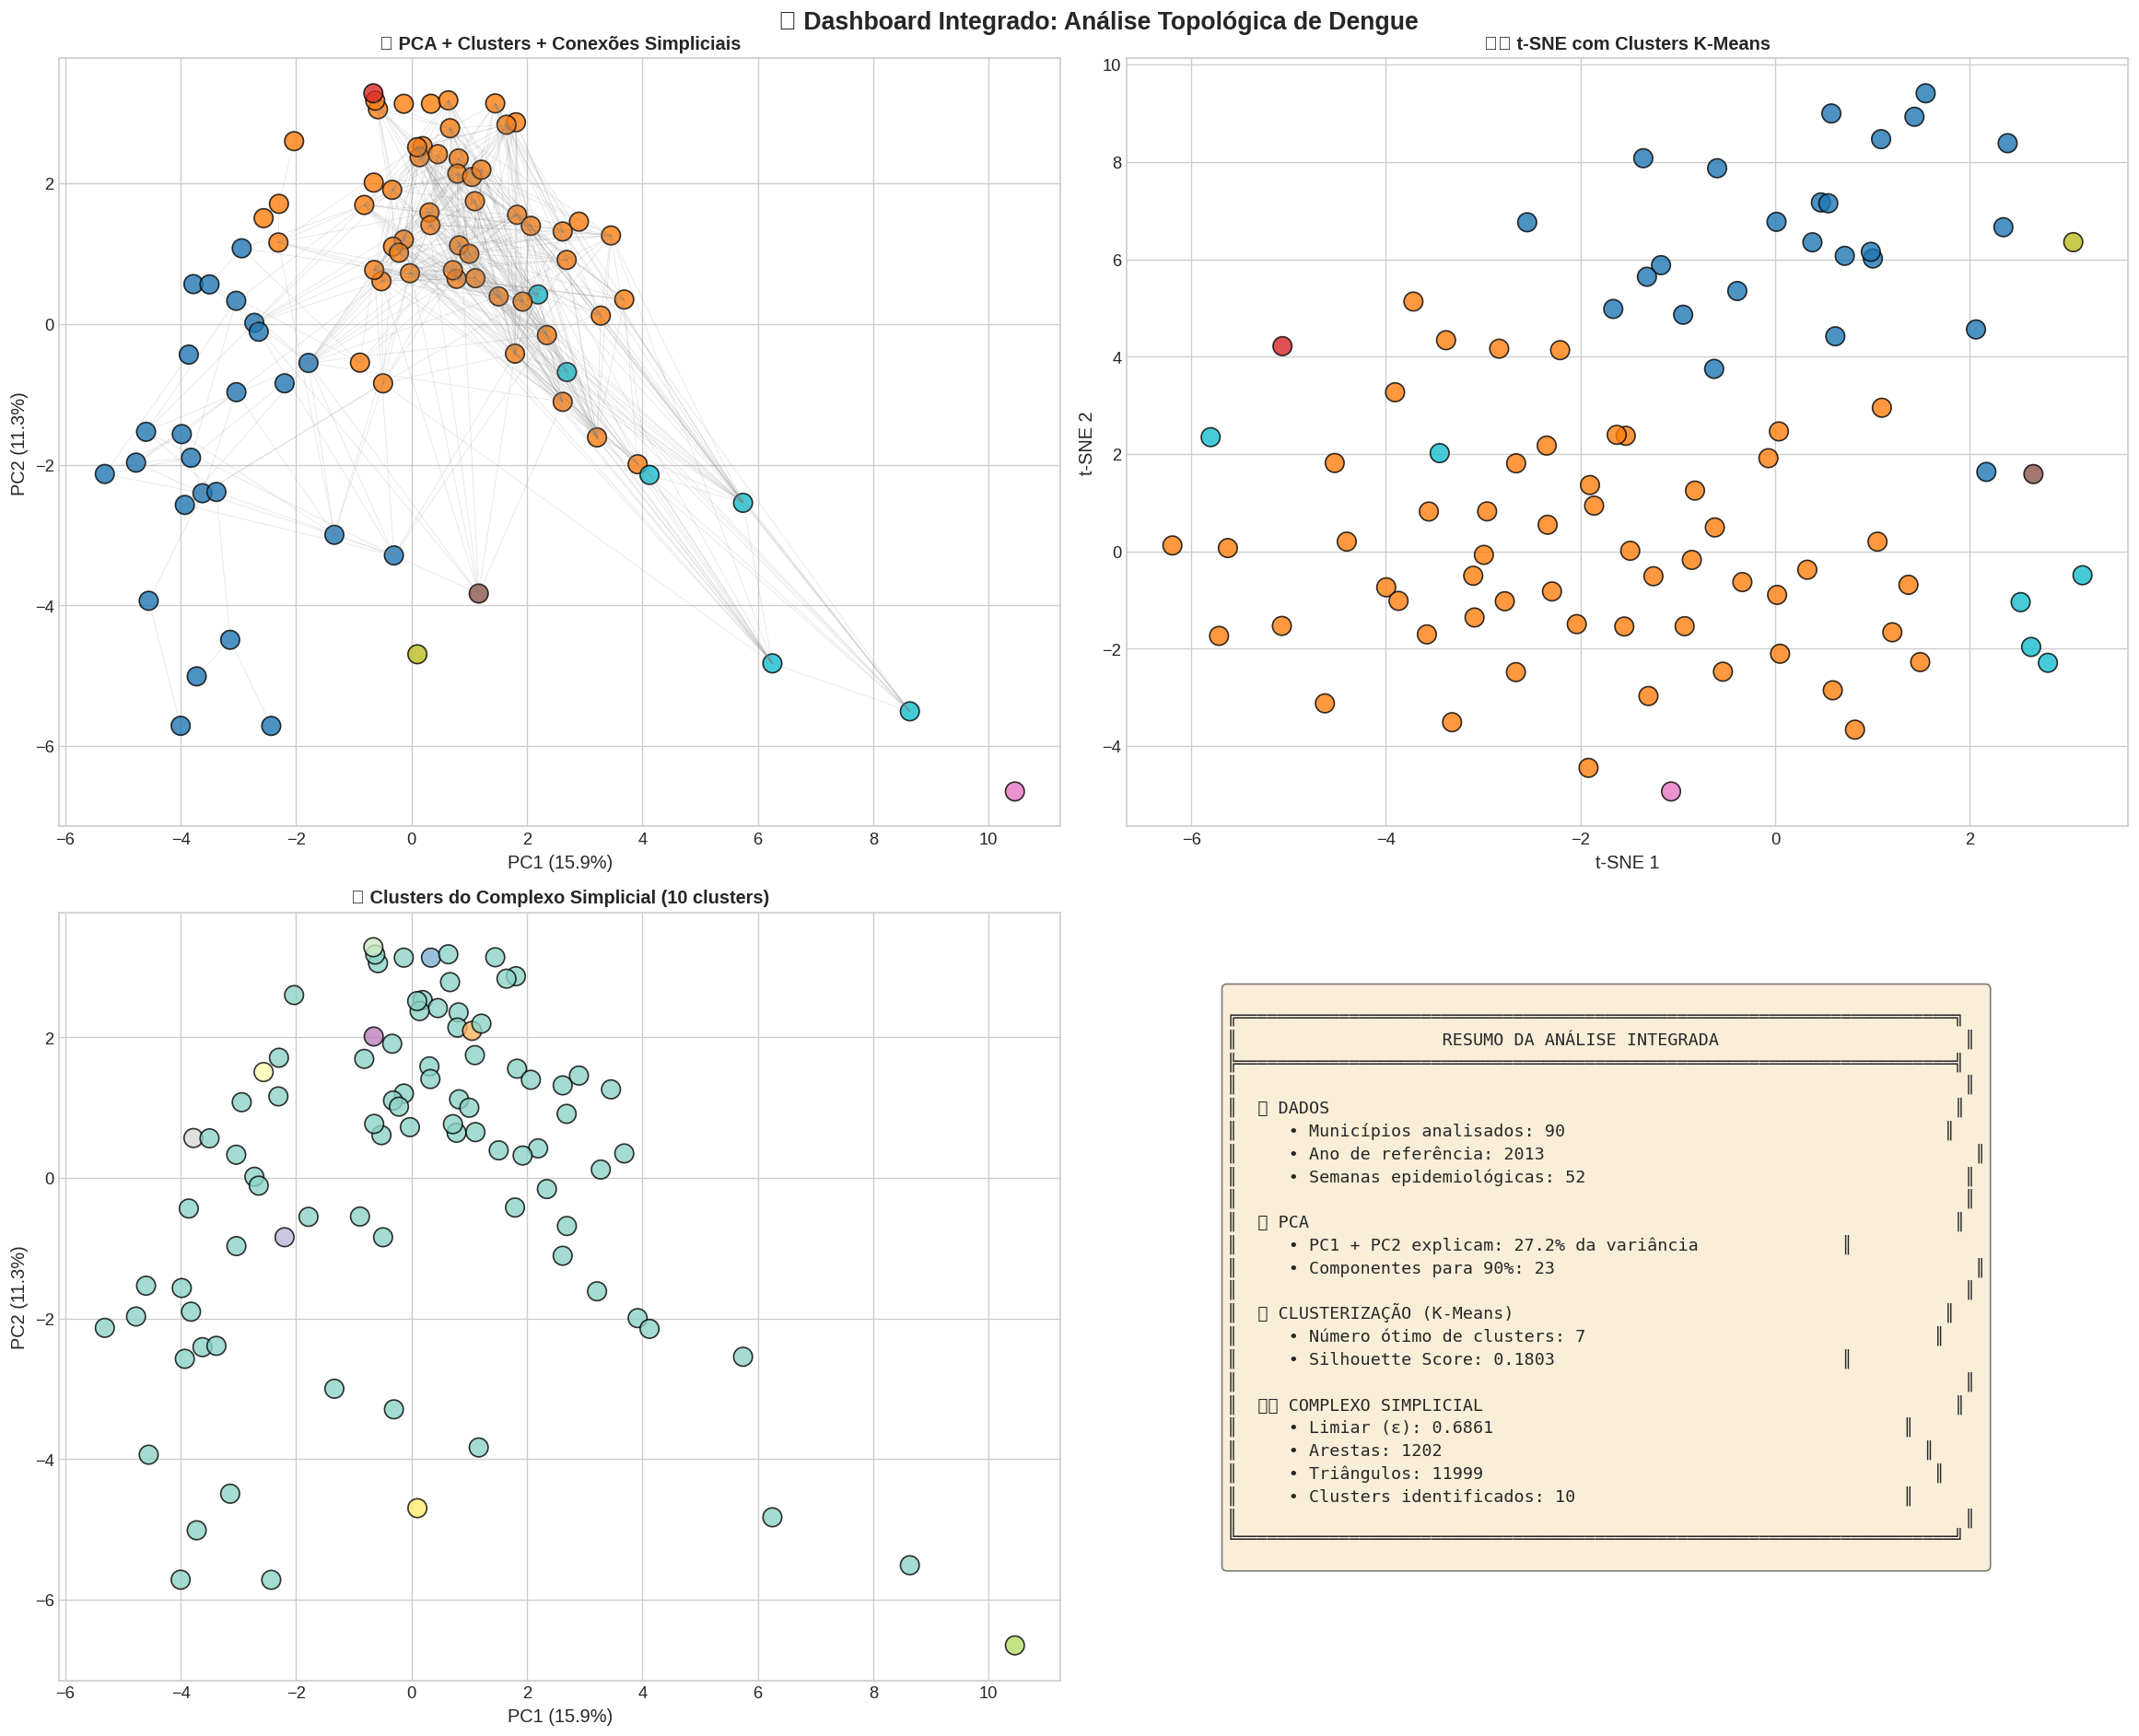

In [23]:
# Dashboard integrado
fig = plt.figure(figsize=(20, 16))

# 1. PCA com clusters e conexões do complexo simplicial
ax1 = fig.add_subplot(2, 2, 1)
scatter1 = ax1.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels, 
                      cmap='tab10', s=150, alpha=0.8, edgecolor='black', linewidth=1)

# Desenhar conexões do complexo simplicial
edges = complex_obj.get_simplices(1)
for edge in list(edges)[:500]:  # Limitar para visualização
    i, j = edge
    ax1.plot([data_pca[i, 0], data_pca[j, 0]], 
            [data_pca[i, 1], data_pca[j, 1]], 
            'gray', alpha=0.2, linewidth=0.5)

ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
ax1.set_title('🔗 PCA + Clusters + Conexões Simpliciais', fontsize=12, fontweight='bold')

# 2. t-SNE colorido por clusters
tsne = TSNE(n_components=2, random_state=42, perplexity=20)
data_tsne = tsne.fit_transform(data_scaled)

ax2 = fig.add_subplot(2, 2, 2)
scatter2 = ax2.scatter(data_tsne[:, 0], data_tsne[:, 1], c=kmeans_labels, 
                      cmap='tab10', s=150, alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
ax2.set_title('🗺️ t-SNE com Clusters K-Means', fontsize=12, fontweight='bold')

# 3. Comparação: Clusters K-Means vs Complexo Simplicial
ax3 = fig.add_subplot(2, 2, 3)

# Atribuir cor do complexo simplicial
simplicial_colors = np.zeros(len(mun_list))
for i, cluster in enumerate(simplicial_clusters):
    for mun in cluster:
        if mun in mun_list:
            idx = mun_list.index(mun)
            simplicial_colors[idx] = i

scatter3 = ax3.scatter(data_pca[:, 0], data_pca[:, 1], c=simplicial_colors, 
                      cmap='Set3', s=150, alpha=0.8, edgecolor='black', linewidth=1)
ax3.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
ax3.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
ax3.set_title(f'🌐 Clusters do Complexo Simplicial ({len(simplicial_clusters)} clusters)', fontsize=12, fontweight='bold')

# 4. Estatísticas comparativas
ax4 = fig.add_subplot(2, 2, 4)
ax4.axis('off')

summary_text = f"""
╔══════════════════════════════════════════════════════════════════════╗
║                    RESUMO DA ANÁLISE INTEGRADA                        ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                       ║
║  📊 DADOS                                                             ║
║     • Municípios analisados: {len(mun_list)}                                     ║
║     • Ano de referência: {YEAR}                                          ║
║     • Semanas epidemiológicas: 52                                     ║
║                                                                       ║
║  📐 PCA                                                               ║
║     • PC1 + PC2 explicam: {pca_2d.explained_variance_ratio_.sum()*100:.1f}% da variância              ║
║     • Componentes para 90%: {n_90}                                         ║
║                                                                       ║
║  🎯 CLUSTERIZAÇÃO (K-Means)                                          ║
║     • Número ótimo de clusters: {optimal_k}                                  ║
║     • Silhouette Score: {silhouette_score(data_scaled, kmeans_labels):.4f}                            ║
║                                                                       ║
║  🕸️ COMPLEXO SIMPLICIAL                                              ║
║     • Limiar (ε): {threshold:.4f}                                        ║
║     • Arestas: {counts.get(1, 0)}                                               ║
║     • Triângulos: {counts.get(2, 0)}                                            ║
║     • Clusters identificados: {len(simplicial_clusters)}                                ║
║                                                                       ║
╚══════════════════════════════════════════════════════════════════════╝
"""
ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('🔬 Dashboard Integrado: Análise Topológica de Dengue', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('output/apresentacao_dashboard_integrado.png', dpi=150, bbox_inches='tight')
plt.show()

📊 CARACTERIZAÇÃO DOS CLUSTERS
 Cluster  N_Municipios  Total_Casos  Populacao  Taxa_Incidencia  Semana_Pico
       0            25        18916     909066      2080.817014            8
       1            55       187727   13468812      1393.790336           14
       2             1           27      10289       262.416173           12
       3             1          133      95492       139.278683           13
       4             1           17      12793       132.885172           12
       5             1           43       9475       453.825858            8
       6             6         5514    1433122       384.754403           15


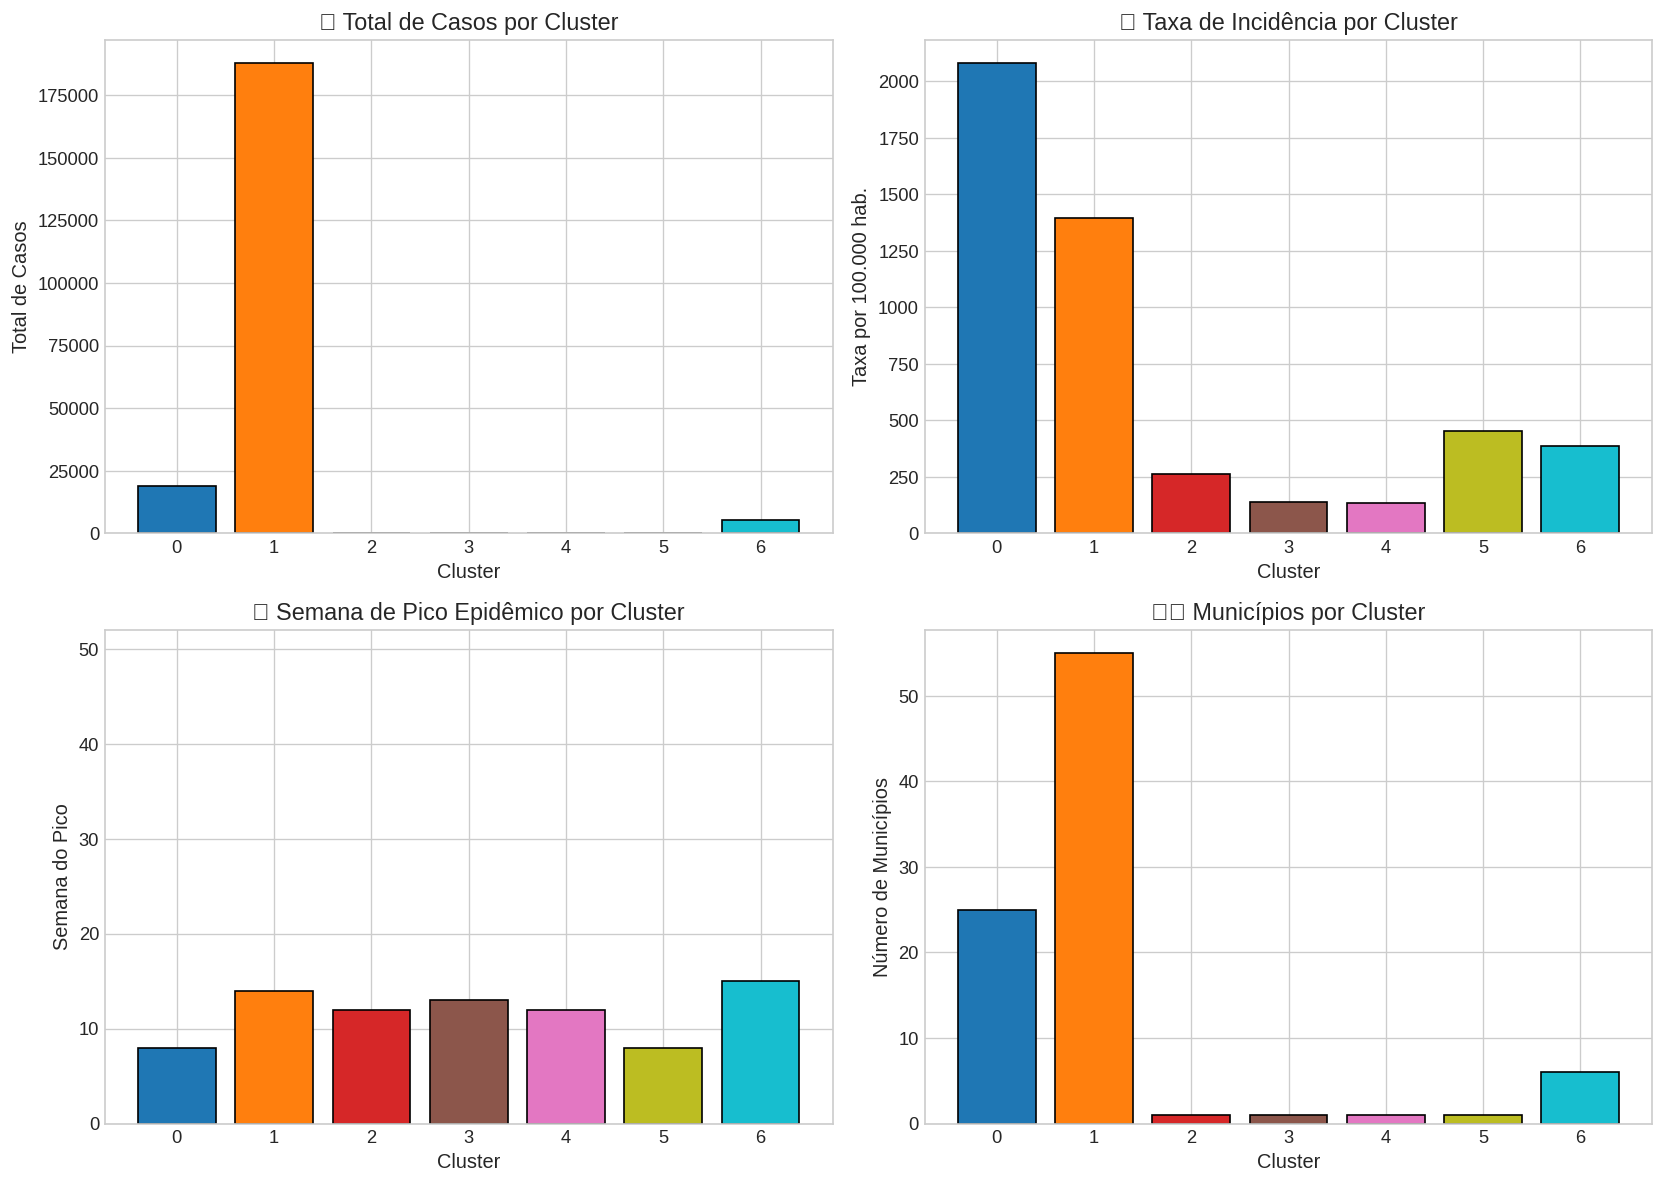

In [24]:
# Análise de características por cluster
print("=" * 70)
print("📊 CARACTERIZAÇÃO DOS CLUSTERS")
print("=" * 70)

cluster_stats = []
for cluster in range(optimal_k):
    mask = kmeans_labels == cluster
    cluster_muns = [m for m, c in zip(municipalities, kmeans_labels) if c == cluster]
    
    # Estatísticas
    cluster_cases = sum(totals[m] for m in cluster_muns)
    cluster_pop = sum(POPULACAO_CENSO_2010[m] for m in cluster_muns)
    cluster_incidence = (cluster_cases / cluster_pop) * 100000
    
    # Pico médio
    cluster_series = np.mean([normalized_series[m] for m in cluster_muns], axis=0)
    peak_week = np.argmax(cluster_series) + 1
    
    cluster_stats.append({
        'Cluster': cluster,
        'N_Municipios': len(cluster_muns),
        'Total_Casos': cluster_cases,
        'Populacao': cluster_pop,
        'Taxa_Incidencia': cluster_incidence,
        'Semana_Pico': peak_week
    })

cluster_stats_df = pd.DataFrame(cluster_stats)
print(cluster_stats_df.to_string(index=False))

# Visualização das características
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total de casos por cluster
axes[0, 0].bar(cluster_stats_df['Cluster'], cluster_stats_df['Total_Casos'], 
              color=plt.cm.tab10(np.linspace(0, 1, optimal_k)), edgecolor='black')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Total de Casos')
axes[0, 0].set_title('📊 Total de Casos por Cluster')

# Taxa de incidência por cluster
axes[0, 1].bar(cluster_stats_df['Cluster'], cluster_stats_df['Taxa_Incidencia'], 
              color=plt.cm.tab10(np.linspace(0, 1, optimal_k)), edgecolor='black')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Taxa por 100.000 hab.')
axes[0, 1].set_title('🏥 Taxa de Incidência por Cluster')

# Semana de pico por cluster
axes[1, 0].bar(cluster_stats_df['Cluster'], cluster_stats_df['Semana_Pico'], 
              color=plt.cm.tab10(np.linspace(0, 1, optimal_k)), edgecolor='black')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Semana do Pico')
axes[1, 0].set_title('📅 Semana de Pico Epidêmico por Cluster')
axes[1, 0].set_ylim(0, 52)

# Número de municípios por cluster
axes[1, 1].bar(cluster_stats_df['Cluster'], cluster_stats_df['N_Municipios'], 
              color=plt.cm.tab10(np.linspace(0, 1, optimal_k)), edgecolor='black')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Número de Municípios')
axes[1, 1].set_title('🏙️ Municípios por Cluster')

plt.tight_layout()
plt.savefig('output/apresentacao_caracteristicas_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. KeplerMapper - Visualização Interativa

O **KeplerMapper** cria visualizações interativas do complexo simplicial que podem ser exploradas no navegador.

> 📁 **Arquivos HTML gerados na pasta `output/`:**
> - `kmapper_pca_2013.html` - Projeção PCA
> - `kmapper_tsne_2013.html` - Projeção t-SNE  
> - `kmapper_l2norm_2013.html` - Norma L2
> - `kmapper_distancia_2013.html` - Baseado em distância L1

In [25]:
# Mostrar preview do KeplerMapper
from IPython.display import IFrame, display, HTML

# Verificar se os arquivos existem
kmapper_files = [
    ('PCA', 'output/kmapper_pca_2013.html'),
    ('t-SNE', 'output/kmapper_tsne_2013.html'),
    ('L2 Norm', 'output/kmapper_l2norm_2013.html'),
    ('Distância L1', 'output/kmapper_distancia_2013.html')
]

print("=" * 70)
print("🗺️ VISUALIZAÇÕES KEPLER MAPPER DISPONÍVEIS")
print("=" * 70)

for name, filepath in kmapper_files:
    if Path(filepath).exists():
        size = Path(filepath).stat().st_size / 1024
        print(f"✅ {name}: {filepath} ({size:.1f} KB)")
    else:
        print(f"❌ {name}: {filepath} (não encontrado)")

print("\n💡 Para visualizar, abra os arquivos HTML no navegador:")
print("   Clique com botão direito -> 'Open with Live Server' ou")
print("   Execute: xdg-open output/kmapper_pca_2013.html")

🗺️ VISUALIZAÇÕES KEPLER MAPPER DISPONÍVEIS
❌ PCA: output/kmapper_pca_2013.html (não encontrado)
❌ t-SNE: output/kmapper_tsne_2013.html (não encontrado)
❌ L2 Norm: output/kmapper_l2norm_2013.html (não encontrado)
❌ Distância L1: output/kmapper_distancia_2013.html (não encontrado)

💡 Para visualizar, abra os arquivos HTML no navegador:
   Clique com botão direito -> 'Open with Live Server' ou
   Execute: xdg-open output/kmapper_pca_2013.html


## 12. Conclusões e Recomendações

### 📊 Principais Achados

In [26]:
# Resumo final
print("=" * 70)
print("📋 CONCLUSÕES DA ANÁLISE EPIDEMIOLÓGICA")
print("=" * 70)

conclusions = """
┌─────────────────────────────────────────────────────────────────────┐
│                     PRINCIPAIS ACHADOS                              │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  1️⃣  PADRÃO TEMPORAL                                                │
│      • Epidemia de dengue segue padrão sazonal bem definido         │
│      • Picos ocorrem entre janeiro e abril (verão/outono)           │
│      • 2013 foi o ano com maior incidência no período               │
│                                                                     │
│  2️⃣  SEMANAS EPIDEMIOLÓGICAS                                        │
│      • 2014 teve 53 semanas epidemiológicas (raro)                  │
│      • Normalização para 52 semanas é necessária para comparações   │
│                                                                     │
│  3️⃣  MUNICÍPIOS SINCRONIZADOS                                       │
│      • Pares como Itaboraí-Rio de Janeiro mostram alta              │
│        sincronização nas curvas epidêmicas                          │
│      • Sincronização sugere dinâmicas compartilhadas                │
│        (mobilidade, clima, vetores)                                 │
│                                                                     │
│  4️⃣  CLUSTERIZAÇÃO                                                  │
│      • Identificamos grupos distintos de municípios                 │
│      • Cada cluster tem perfil epidêmico característico             │
│      • Alguns clusters têm picos mais precoces, outros tardios      │
│                                                                     │
│  5️⃣  COMPLEXOS SIMPLICIAIS                                          │
│      • Revelam estrutura topológica das relações entre municípios   │
│      • Triângulos indicam trios com dinâmicas similares             │
│      • Útil para definir regiões de vigilância coordenada           │
│                                                                     │
│  6️⃣  PCA                                                            │
│      • Poucos componentes capturam maioria da variação              │
│      • PC1 relacionado à intensidade geral do surto                 │
│      • PC2 captura diferenças no timing dos picos                   │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
"""
print(conclusions)

recommendations = """
┌─────────────────────────────────────────────────────────────────────┐
│                     RECOMENDAÇÕES                                   │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  🎯 VIGILÂNCIA EPIDEMIOLÓGICA                                       │
│     • Coordenar ações entre municípios do mesmo cluster             │
│     • Municípios altamente conectados no complexo simplicial        │
│       devem compartilhar informações em tempo real                  │
│                                                                     │
│  📅 PLANEJAMENTO TEMPORAL                                           │
│     • Intensificar ações preventivas antes da semana 1              │
│     • Manter vigilância aumentada até semana 17                     │
│                                                                     │
│  🏥 ALOCAÇÃO DE RECURSOS                                            │
│     • Priorizar municípios com alta taxa de incidência              │
│     • Considerar tamanho populacional para capacidade hospitalar    │
│                                                                     │
│  🔬 PESQUISAS FUTURAS                                               │
│     • Investigar fatores que explicam sincronização                 │
│     • Aplicar análise a outros anos e regiões                       │
│     • Correlacionar com dados climáticos e entomológicos            │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
"""
print(recommendations)

📋 CONCLUSÕES DA ANÁLISE EPIDEMIOLÓGICA

┌─────────────────────────────────────────────────────────────────────┐
│                     PRINCIPAIS ACHADOS                              │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  1️⃣  PADRÃO TEMPORAL                                                │
│      • Epidemia de dengue segue padrão sazonal bem definido         │
│      • Picos ocorrem entre janeiro e abril (verão/outono)           │
│      • 2013 foi o ano com maior incidência no período               │
│                                                                     │
│  2️⃣  SEMANAS EPIDEMIOLÓGICAS                                        │
│      • 2014 teve 53 semanas epidemiológicas (raro)                  │
│      • Normalização para 52 semanas é necessária para comparações   │
│                                                                     │
│  3️⃣  MUNICÍPIOS SIN

In [27]:
# Lista de todos os arquivos gerados
print("=" * 70)
print("📁 ARQUIVOS GERADOS NESTA ANÁLISE")
print("=" * 70)

output_files = list(Path('output').glob('*.png')) + list(Path('output').glob('*.csv')) + list(Path('output').glob('*.html'))
output_files = sorted(output_files)

print(f"\n📊 Visualizações PNG: {len([f for f in output_files if f.suffix == '.png'])}")
print(f"📄 Dados CSV: {len([f for f in output_files if f.suffix == '.csv'])}")
print(f"🌐 Interativos HTML: {len([f for f in output_files if f.suffix == '.html'])}")
print(f"\n{'─' * 70}")

for f in output_files:
    size = f.stat().st_size / 1024
    emoji = "📊" if f.suffix == '.png' else "📄" if f.suffix == '.csv' else "🌐"
    print(f"  {emoji} {f.name} ({size:.1f} KB)")

📁 ARQUIVOS GERADOS NESTA ANÁLISE

📊 Visualizações PNG: 15
📄 Dados CSV: 0
🌐 Interativos HTML: 0

──────────────────────────────────────────────────────────────────────
  📊 apresentacao_caracteristicas_clusters.png (122.0 KB)
  📊 apresentacao_clusters_pca.png (196.0 KB)
  📊 apresentacao_complexo_simplicial.png (2738.2 KB)
  📊 apresentacao_curvas_ano.png (178.1 KB)
  📊 apresentacao_dados_gerais.png (81.2 KB)
  📊 apresentacao_dashboard_integrado.png (874.5 KB)
  📊 apresentacao_dendrograma.png (217.4 KB)
  📊 apresentacao_distribuicao_distancias.png (83.0 KB)
  📊 apresentacao_incidencia.png (184.4 KB)
  📊 apresentacao_kmeans_avaliacao.png (112.8 KB)
  📊 apresentacao_pares_sincronizados.png (367.9 KB)
  📊 apresentacao_pca_projecao.png (249.6 KB)
  📊 apresentacao_pca_variancia.png (89.7 KB)
  📊 apresentacao_perfis_clusters.png (447.4 KB)
  📊 apresentacao_simplicial_limiares.png (120.7 KB)
